# Introduction

This is an experimentation with the ideas put forward in the paper [Retrieval of 
similar chess positions](https://doi.org/10.1145/2600428.2609605).

In [1]:
# Set up the Java VM for Lucene
import lucene

try:
    print("Initializing VM")
    lucene.initVM(vmargs=['-Djava.awt.headless=true'])  # This needs to be run once to get it all going
except ValueError as e:
    print("VM already initialized")

Initializing VM


## Indexing
The paper put forward a series of ideas to index chess positions. Let us experiment with the ideas as they are introduced in the paper.

### Only piece position
The most basic idea that the paper introduces is that of representing the chess board as a encoding of pieces at a specific location. This is an encoding that neither matches the common PGN nor the FEN encoding. As such we first need to find a way to generate the data in this format.

#### Exploring the chess library

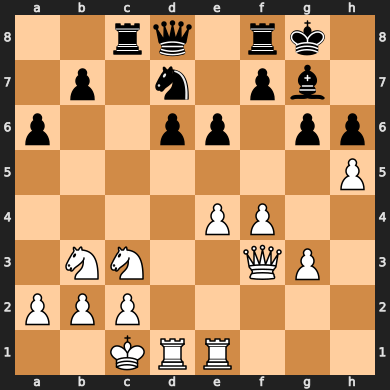

7
7
7
7
6
6
5
5
5
5
5
4
3
3
2
2
2
2
0
0
0
26
26
{'pb7', 'g3', 'pf7'}
{'Pg3', 'b7', 'f7'}
65280


In [47]:
import chess

import chess.svg
board = chess.Board("2rq1rk1/1p1n1pb1/p2pp1pp/7P/4PP2/1NN2QP1/PPP5/2KRR3 b - - 1 20")
chess.svg.board(board, size=350)
display(board)
board.piece_map()

# for move in board.legal_moves:
#     print(board.san(move))

check = set()
for square, piece in board.piece_map().items():
    if piece.piece_type == chess.PAWN and (chess.square_rank(square) == 1 or chess.square_rank(square) == 6):
        check.add(chess.square_name(square))
        # print(f"{chess.square_name(square)}")
    else:
        print( chess.square_rank(square))
        check.add(piece.symbol() + chess.square_name(square))
        # print(f"{piece.symbol()}{chess.square_name(square)}")

control = set(['rc8', 'qd8', 'rf8', 'kg8', 'pb7', 'nd7', 'pf7', 'bg7', 'pa6', 'pd6', 'pe6', 'pg6', 'ph6', 'Ph5',
'Pe4', 'Pf4', 'Nb3', 'Nc3', 'Qf3', 'g3', 'a2', 'b2', 'c2', 'Kc1', 'Rd1', 'Re1'])

print(len(control))
print(len(check))
print (control - check)
print (check - control)
print(chess.BB_RANK_2  )

In [3]:
pgn = '''1. e4 { [%clk 0:01:00] } 1... c5 { [%clk 0:01:00] } 2. Nf3 { [%clk 0:00:59] } 2... Nc6 { [%clk 0:01:00] } 3. c3 { [%clk 0:00:58] } 3... e5 { [%clk 0:00:59] } 4. d4 { [%clk 0:00:58] } 4... cxd4 { [%clk 0:00:59] } 5. cxd4 { [%clk 0:00:58] } 5... exd4 { [%clk 0:00:59] } 6. Nxd4 { [%clk 0:00:57] } 6... Nf6 { [%clk 0:00:59] } 7. Nxc6 { [%clk 0:00:56] } 7... bxc6 { [%clk 0:00:59] } 8. Nc3 { [%clk 0:00:56] } 8... Bb4 { [%clk 0:00:58] } 9. f3 { [%clk 0:00:54] } 9... O-O { [%clk 0:00:57] } 10. Bd2 { [%clk 0:00:53] } 10... a5 { [%clk 0:00:57] } 11. a3 { [%clk 0:00:52] } 11... 
Be7 { [%clk 0:00:56] } 12. Bc4 { [%clk 0:00:51] } 12... Ba6 { [%clk 0:00:56] } 13. Qe2 { [%clk 0:00:50] } 13... Bxc4 { [%clk 0:00:54] } 14. Qxc4 { [%clk 0:00:50] } 14... Qc7 { [%clk 0:00:54] 
} 15. O-O { [%clk 0:00:49] } 15... Rac8 { [%clk 0:00:53] } 16. Qd3 { [%clk 0:00:48] } 16... Rfd8 { [%clk 0:00:52] } 17. Bg5 { [%clk 0:00:45] } 17... h6 { [%clk 0:00:51] } 18. Bxf6 { [%clk 0:0
0:44] } 18... Bxf6 { [%clk 0:00:51] } 19. Rad1 { [%clk 0:00:43] } 19... Qb6+ { [%clk 0:00:49] } 20. Kh1 { [%clk 0:00:37] } 20... Qxb2 { [%clk 0:00:48] } 21. Ne2 { [%clk 0:00:37] } 21... c5 { 
[%clk 0:00:45] } 22. Rd2 { [%clk 0:00:37] } 22... Qe5 { [%clk 0:00:43] } 23. Nc1 { [%clk 0:00:34] } 23... c4 { [%clk 0:00:42] } 24. Qe2 { [%clk 0:00:34] } 24... c3 { [%clk 0:00:41] } 25. Na2 
{ [%clk 0:00:34] } 25... cxd2 { [%clk 0:00:40] } 26. Nc3 { [%clk 0:00:33] } 26... Qxc3 { [%clk 0:00:39] } 27. Qf2 { [%clk 0:00:32] } 27... Qc1 { [%clk 0:00:37] } 28. Qg3 { [%clk 0:00:32] } 28
... Qxf1# { [%clk 0:00:36] } 0-1'''

import chess.pgn
import io

game = chess.pgn.read_game(io.StringIO(pgn))
cur_board = game.board()

def func(game):
    for move in game.mainline_moves():
        cur_board.push(move)
        t = (cur_board.fen())

%time func(game)

def func2(game):
    while game.next():
        game=game.next()
        t = (game.board().fen())

%time func2(game)

CPU times: user 2.04 ms, sys: 1 µs, total: 2.04 ms
Wall time: 2.04 ms
CPU times: user 7.85 ms, sys: 73 µs, total: 7.93 ms
Wall time: 7.94 ms


In [3]:
import chess.pgn
num_games = 0

# Open the PGN file
with open("test_subset.pgn") as pgn_file:
    game = chess.pgn.read_game(pgn_file)
    
    while game is not None:
        # Do something with the game
        game = chess.pgn.read_game(pgn_file)
        num_games += 1
    
# Print the number of games
print(f"The number of games in 'test_subset.pgn' is: {num_games}")


The number of games in 'test_subset.pgn' is: 50


#### Observation
The code that we used till now to generate the dataset was very sub optimal since the library didn't cache the previous calculation causing the complexity to be O(n^2) instead of O(n).

In [ ]:
import os
import chess.pgn

# TODO: THis is the simple one for now can become more complex later
def board_position(board):
    output = ""
    
    for square, piece in board.piece_map().items():
        output += " " + piece.symbol()+chess.square_name(square)
    
    return output

num_games = 0
# Open the PGN file
with open("test_subset.pgn") as pgn_file:
    game = chess.pgn.read_game(pgn_file)
    
    while game:
        num_games += 1
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break
        
        # Create the directory
        path = game.headers["Site"]
        id = path[path.rfind("/")+1:]
        dir_path = "./z_converter/" + id
        # print(dir_path)
        os.makedirs(dir_path, exist_ok=True)
        
        # Loop over the game and generate the files in the directory
        move_counter = 0
        board = game.board()
        for move in game.mainline_moves():
            move_counter += 1
            board.push(move)
            
            with open(dir_path + "/" + str(move_counter) + ".txt", "w") as f:
                f.write(board_position(board))
                
# Print the number of games
print(f"The number of games in 'test_subset.pgn' is: {num_games}")

### Indexing subset of the Dataset

In [2]:
import sys, os, lucene, threading, time
from datetime import datetime
from java.nio.file import Paths
from org.apache.lucene.analysis.miscellaneous import LimitTokenCountAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer
from org.apache.lucene.document import Document, Field, FieldType
from org.apache.lucene.index import FieldInfo, IndexWriter, IndexWriterConfig, IndexOptions
from org.apache.lucene.store import NIOFSDirectory


class Ticker(object):
    def __init__(self):
        self.tick = True

    def run(self):
        while self.tick:
            sys.stdout.write('.')
            sys.stdout.flush()
            time.sleep(1.0)

class IndexFiles(object):
    def __init__(self, root, storeDir, analyzer):
        if not os.path.exists(storeDir):
            os.mkdir(storeDir)

        store = NIOFSDirectory(Paths.get(storeDir))
        analyzer = LimitTokenCountAnalyzer(analyzer, 1048576)
        config = IndexWriterConfig(analyzer)
        config.setOpenMode(IndexWriterConfig.OpenMode.CREATE)
        writer = IndexWriter(store, config)

        self.indexDocs(root, writer)
        ticker = Ticker()
        print ('commit index'),
        threading.Thread(target=ticker.run).start()
        writer.commit()
        writer.close()
        ticker.tick = False
        print ('done')

    def indexDocs(self, root, writer):
        t1 = FieldType()
        t1.setStored(True)
        t1.setTokenized(False)
        t1.setIndexOptions(IndexOptions.DOCS_AND_FREQS)

        t2 = FieldType()
        t2.setStored(False)
        t2.setTokenized(True)
        t2.setIndexOptions(IndexOptions.DOCS_AND_FREQS_AND_POSITIONS) # TODO: This might be overkill

        for root, dirnames, filenames in os.walk(root):
            for filename in filenames:
                if not filename.endswith('.txt'):
                    continue
                # print ("adding", filename)
                try:
                    path = os.path.join(root, filename)
                    file = open(path)
                    contents = str(file.read())
                    file.close()
                    doc = Document()
                    doc.add(Field("name", filename, t1))
                    doc.add(Field("path", root, t1))
                    if len(contents) > 0:
                        doc.add(Field("contents", contents, t2))
                    else:
                        print ("warning: no content in %s" % filename)
                    writer.addDocument(doc)
                except Exception as e:
                    print ("Failed in indexDocs:", e)

start = datetime.now()
try:
    IndexFiles("./z_converter/", "./zTest.index", WhitespaceAnalyzer())
except Exception as e:
    print ("Failed: ", e)
    raise e
end = datetime.now()
print (end - start)

commit index
.done
0:00:00.752524


In [17]:
# Query the index
from java.nio.file import Paths
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import NIOFSDirectory
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.search.similarities import BM25Similarity

def run(searcher, analyzer, command):
    print ("Searching for:", command)
    escaped_command = command.replace("/", "\\/")
    query = QueryParser("contents", analyzer).parse(escaped_command)
    scoreDocs = searcher.search(query, 10).scoreDocs
    print ("%s total matching documents." % len(scoreDocs))

    for scoreDoc in scoreDocs:        
        doc = searcher.doc(scoreDoc.doc)
        path = os.path.join(doc.get("path"), doc.get("name"))
        file = open(path)
        content = str(file.read())
        file.close()
        
        print (scoreDoc.score)
        print(path)
        print(set(content.split(" ")) & set(command.split(" ")))
        print(len(content.split(" ")))

directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/zTest.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
searcher.setSimilarity(BM25Similarity())
analyzer = WhitespaceAnalyzer()

run(searcher, analyzer, command="bc6 pa5 Pe4 Pd4 Bc4 bb4 Nc3")
del searcher

Searching for: bc6 pa5 Pe4 Pd4 Bc4 bb4 Nc3
10 total matching documents.
7.618467330932617
./z_converter/zE9VI455/26.txt
{'Pd4', 'Bc4', 'bb4', 'Pe4', 'Nc3', 'pa5', 'bc6'}
28
7.618467330932617
./z_converter/zE9VI455/25.txt
{'Pd4', 'Bc4', 'bb4', 'Pe4', 'Nc3', 'pa5', 'bc6'}
28
6.961613178253174
./z_converter/zE9VI455/24.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5', 'bc6'}
28
6.939178466796875
./z_converter/zE9VI455/28.txt
{'Pd4', 'Bc4', 'bb4', 'Pe4', 'pa5', 'bc6'}
28
6.939178466796875
./z_converter/zE9VI455/27.txt
{'Pd4', 'Bc4', 'bb4', 'Pe4', 'pa5', 'bc6'}
28
5.488282203674316
./z_converter/zE9VI455/29.txt
{'Pd4', 'Bc4', 'Pe4', 'pa5', 'bc6'}
27
5.319634437561035
./z_converter/zE9VI455/20.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28
5.319634437561035
./z_converter/zE9VI455/21.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28
5.319634437561035
./z_converter/zE9VI455/23.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28
5.319634437561035
./z_converter/zE9VI455/22.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28


In [14]:
directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/zTest.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
analyzer = WhitespaceAnalyzer()

run(searcher, analyzer, command="bc6 pa5 Pe4^1.5 Pd4 Bc4 bb4 Nc3")
del searcher

Searching for: bc6 pa5 Pe4^1.5 Pd4 Bc4 bb4 Nc3
10 total matching documents.
7.946894645690918
./z_converter/zE9VI455/26.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5', 'bc6'}
28
7.946894645690918
./z_converter/zE9VI455/25.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5', 'bc6'}
28
7.267605781555176
./z_converter/zE9VI455/28.txt
{'Pd4', 'Bc4', 'bb4', 'pa5', 'bc6'}
28
7.267605781555176
./z_converter/zE9VI455/27.txt
{'Pd4', 'Bc4', 'bb4', 'pa5', 'bc6'}
28
6.961613178253174
./z_converter/zE9VI455/24.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5', 'bc6'}
28
5.822225570678711
./z_converter/zE9VI455/29.txt
{'pa5', 'Pd4', 'bc6', 'Bc4'}
27
5.319634437561035
./z_converter/zE9VI455/20.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28
5.319634437561035
./z_converter/zE9VI455/21.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28
5.319634437561035
./z_converter/zE9VI455/23.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28
5.319634437561035
./z_converter/zE9VI455/22.txt
{'Pd4', 'Bc4', 'bb4', 'Nc3', 'pa5'}
28


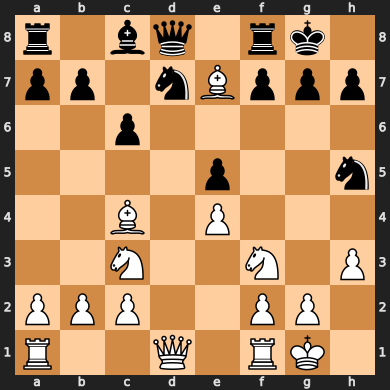

In [7]:
import chess

# Find a way to recover the board from the terms
terms =  " kg8 rf8 qd8 bc8 ra8 ph7 pg7 pf7 Be7 nd7 pb7 pa7 pc6 nh5 pe5 Pe4 Bc4 Ph3 Nf3 Nc3 Pg2 Pf2 Pc2 Pb2 Pa2 Kg1 Rf1 Qd1 Ra1 "
board = chess.Board()
# TODO: Make this a function for later
board.set_piece_map({chess.parse_square(term[1:]): chess.Piece.from_symbol(term[0]) for term in terms.strip().split(" ")})
display(board)

In [75]:
# r-closure of the board (only caveat is that the pawns only consider forward not backwards)
val_map = {i: str(1 - (7 * i / 64)) for i in range(1, 9)}

board.turn = chess.WHITE
w_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move)]
w_r_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)], w_none_capture_moves))

board.turn = chess.BLACK
b_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move)]
b_r_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)], b_none_capture_moves))

w_r_closure + b_r_closure

['Bf6^0.890625',
 'Bd6^0.890625',
 'Bg5^0.78125',
 'Bc5^0.78125',
 'Bh4^0.671875',
 'Bb4^0.671875',
 'Ba3^0.5625',
 'Be6^0.78125',
 'Ba6^0.78125',
 'Bd5^0.890625',
 'Bb5^0.890625',
 'Bd3^0.890625',
 'Bb3^0.890625',
 'Be2^0.78125',
 'Ng5^0.78125',
 'Nh4^0.78125',
 'Nd4^0.78125',
 'Nh2^0.78125',
 'Nd2^0.78125',
 'Ne1^0.78125',
 'Nd5^0.78125',
 'Nb5^0.78125',
 'Na4^0.78125',
 'Ne2^0.78125',
 'Nb1^0.78125',
 'Kh2^0.890625',
 'Kh1^0.890625',
 'Re1^0.890625',
 'Qd6^0.453125',
 'Qd5^0.5625',
 'Qd4^0.671875',
 'Qd3^0.78125',
 'Qe2^0.890625',
 'Qd2^0.890625',
 'Qe1^0.890625',
 'Qc1^0.890625',
 'Qb1^0.78125',
 'Rc1^0.78125',
 'Rb1^0.890625',
 'Ph4^0.890625',
 'Pg3^0.890625',
 'Pb3^0.890625',
 'Pa3^0.890625',
 'Pg4^0.78125',
 'Pb4^0.78125',
 'Pa4^0.78125',
 'kh8^0.890625',
 're8^0.890625',
 'qe8^0.890625',
 'qc7^0.890625',
 'qb6^0.78125',
 'qa5^0.671875',
 'rb8^0.890625',
 'nb8^0.78125',
 'nf6^0.78125',
 'nb6^0.78125',
 'nc5^0.78125',
 'nf6^0.78125',
 'nf4^0.78125',
 'ng3^0.78125',
 'ph6^0.890625

In [79]:
# a-closure of the board
board.turn = chess.WHITE
w_capture_moves = [move for move in board.legal_moves if board.is_capture(move)]
w_a_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square), w_capture_moves))

board.turn = chess.BLACK
b_capture_moves = [move for move in board.legal_moves if board.is_capture(move)]
b_a_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square), b_capture_moves))

w_a_closure + b_a_closure

['B>rf8', 'B>qd8', 'B>pf7', 'N>pe5', 'Q>nd7', 'q>Be7']

In [81]:
# Castling seems to work fine
fen = "rnbqkbnr/ppp2pp1/3p3p/4p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4"
board = chess.Board(fen)
board.turn = chess.WHITE
board.legal_moves

board.turn = chess.WHITE
w_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move) ]
w_r_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)], w_none_capture_moves))

board.turn = chess.BLACK
b_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move)]
b_r_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)], b_none_capture_moves))

w_r_closure + b_r_closure

['Be6^0.78125',
 'Ba6^0.78125',
 'Bd5^0.890625',
 'Bb5^0.890625',
 'Bd3^0.890625',
 'Bb3^0.890625',
 'Be2^0.78125',
 'Bf1^0.671875',
 'Ng5^0.78125',
 'Nh4^0.78125',
 'Nd4^0.78125',
 'Ng1^0.78125',
 'Rg1^0.890625',
 'Rf1^0.78125',
 'Ke2^0.890625',
 'Kf1^0.890625',
 'Qe2^0.890625',
 'Nc3^0.78125',
 'Na3^0.78125',
 'Kg1^0.78125',
 'Ph3^0.890625',
 'Pg3^0.890625',
 'Pd3^0.890625',
 'Pc3^0.890625',
 'Pb3^0.890625',
 'Pa3^0.890625',
 'Ph4^0.78125',
 'Pg4^0.78125',
 'Pd4^0.78125',
 'Pb4^0.78125',
 'Pa4^0.78125',
 'rh7^0.890625',
 'ne7^0.78125',
 'nf6^0.78125',
 'be7^0.890625',
 'ke7^0.890625',
 'kd7^0.890625',
 'qe7^0.890625',
 'qd7^0.890625',
 'qf6^0.78125',
 'qg5^0.671875',
 'qh4^0.5625',
 'bd7^0.890625',
 'be6^0.78125',
 'bf5^0.671875',
 'bg4^0.5625',
 'bh3^0.453125',
 'nd7^0.78125',
 'nc6^0.78125',
 'na6^0.78125',
 'pg6^0.890625',
 'pf6^0.890625',
 'pc6^0.890625',
 'pb6^0.890625',
 'pa6^0.890625',
 'ph5^0.890625',
 'pd5^0.890625',
 'pg5^0.78125',
 'pf5^0.78125',
 'pc5^0.78125',
 'pb5^0.78

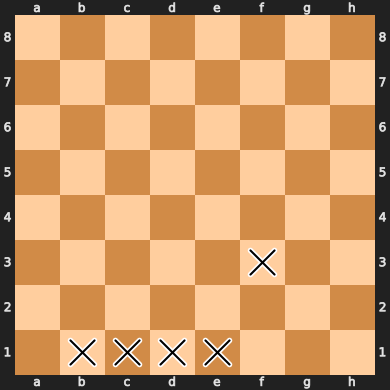

In [5]:
board.attackers(chess.WHITE, chess.D2)  # defenders

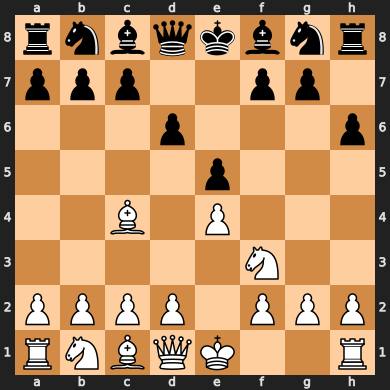

['r<ng8',
 'k<bf8',
 'k<qd8',
 'q<bc8',
 'r<nb8',
 'b<pg7',
 'k<pf7',
 'q<pc7',
 'b<pb7',
 'r<pa7',
 'p<ph6',
 'n<ph6',
 'r<ph6',
 'p<pd6',
 'q<pd6',
 'b<pd6',
 'p<pe5',
 'Q<Nf3',
 'P<Nf3',
 'R<Ph2',
 'N<Ph2',
 'K<Pf2',
 'N<Pd2',
 'B<Pd2',
 'Q<Pd2',
 'K<Pd2',
 'N<Pd2',
 'Q<Pc2',
 'B<Pb2',
 'R<Pa2',
 'B<Pa2',
 'K<Qd1',
 'Q<Bc1',
 'R<Nb1']

In [12]:
import chess

# d-closure
fen = "rnbqkbnr/ppp2pp1/3p3p/4p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 4"
board = chess.Board(fen)
display(board)

d_closure = []

# Loop over all pieces of the different colors and check if there are pieces of the same color defending the position if so the piece on that position is defended.
for square, piece in board.piece_map().items():
    if piece.piece_type != chess.KING: # Defending a king doesn't really make sense
        def_position = board.attackers(piece.color, square)
        piece_notation = piece.symbol() + chess.square_name(square)
        d_closure += [board.piece_at(x).symbol() + '<' + piece_notation for x in def_position]

d_closure

### Testing the closures

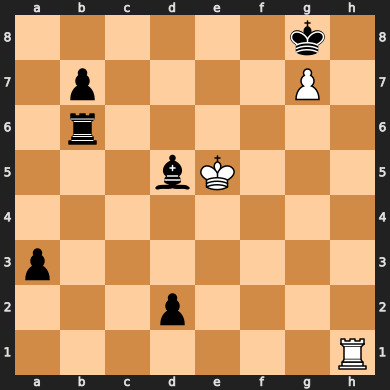

In [43]:
fen = "6k1/1p4P1/1r6/3bK3/8/p7/3p4/7R b - - 3 47"
board = chess.Board(fen)
display(board)

In [44]:
val_map = {i: str(1 - (7 * i / 64)) for i in range(1, 9)}

# TODO: Not yet hyper optimized
def r_closure(board):
    t = board.turn
    board.turn = chess.WHITE
    
    w_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move)]
    w_r_closure = [board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)] for x in w_none_capture_moves]
    # w_r_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)], w_none_capture_moves))

    board.turn = chess.BLACK
    b_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move)]
    b_r_closure = [board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)] for x in b_none_capture_moves]
    # b_r_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)], b_none_capture_moves))
    
    board.turn = t
    return w_r_closure + b_r_closure


def a_closure(board):
    #FIXME: This ignores en passant attacks for now since they are a bit tricky
    t = board.turn
    
    board.turn = chess.WHITE
    w_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    w_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in w_capture_moves]
    # w_a_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square), w_capture_moves))
 
    board.turn = chess.BLACK
    b_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    b_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in b_capture_moves]
    # b_a_closure= list(map(lambda x: board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square), b_capture_moves))

    board.turn = t
    return w_a_closure + b_a_closure

def d_closure(board):
    d_closure = []

    for square, piece in board.piece_map().items():
        if piece.piece_type != chess.KING: # Defending a king doesn't really make sense
            d_closure += [board.piece_at(x).symbol() + '<' + piece.symbol() + chess.square_name(square) for x in board.attackers(piece.color, square)]

    return d_closure

def p_closure(board):
    return [p.symbol()+chess.square_name(s) for s,p in board.piece_map().items()]


%time t1 = (r_closure(board))
%time t2 = (a_closure(board))
%time t3 = (d_closure(board))
%time t4 = (p_closure(board))

print(t1)
print(t2)
print(t3)
print(t4)

CPU times: user 304 µs, sys: 1 µs, total: 305 µs
Wall time: 309 µs
CPU times: user 178 µs, sys: 0 ns, total: 178 µs
Wall time: 189 µs
CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 63.9 µs
CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 20 µs
['Kf5^0.890625', 'Kf4^0.890625', 'Kd4^0.890625', 'Rh8^0.234375', 'Rh7^0.34375', 'Rh6^0.453125', 'Rh5^0.5625', 'Rh4^0.671875', 'Rh3^0.78125', 'Rh2^0.890625', 'Rg1^0.890625', 'Rf1^0.78125', 'Re1^0.671875', 'Rd1^0.5625', 'Rc1^0.453125', 'Rb1^0.34375', 'Ra1^0.234375', 'kf7^0.890625', 'rh6^0.34375', 'rg6^0.453125', 'rf6^0.5625', 're6^0.671875', 'rd6^0.78125', 'rc6^0.890625', 'ra6^0.890625', 'rb5^0.890625', 'rb4^0.78125', 'rb3^0.671875', 'rb2^0.5625', 'rb1^0.453125', 'bf7^0.78125', 'be6^0.890625', 'bc6^0.890625', 'be4^0.890625', 'bc4^0.890625', 'bf3^0.78125', 'bb3^0.78125', 'bg2^0.671875', 'ba2^0.671875', 'pa2^0.890625', 'pd1^0.890625', 'pd1^0.890625', 'pd1^0.890625', 'pd1^0.890625']
['K>bd5', 'k>Pg7', 'b>Rh1']
['b<pb7', 'r<pb7']
['

In [47]:
%%writefile ./convert_games.py 

import os
import chess.pgn

NUM_MOVES_SKIP = 12  # Skip the first 12 moves of the games since these are usually theory

def a_closure(board):
    #FIXME: This ignores en passant attacks for now since they are a bit tricky
    t = board.turn
    
    board.turn = chess.WHITE
    w_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    w_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in w_capture_moves]

    board.turn = chess.BLACK
    b_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    b_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in b_capture_moves]

    board.turn = t
    return w_a_closure + b_a_closure

def d_closure(board):
    d_closure = []

    for square, piece in board.piece_map().items():
        if piece.piece_type != chess.KING: # Defending a king doesn't really make sense
            d_closure += [board.piece_at(x).symbol() + '<' + piece.symbol() + chess.square_name(square) for x in board.attackers(piece.color, square)]

    return d_closure

def p_closure(board):
    return [p.symbol()+chess.square_name(s) for s,p in board.piece_map().items()]


num_games = 0

# Open the PGN file
with open("./PGN/test_subset.pgn") as pgn_file:
    game = chess.pgn.read_game(pgn_file)
    
    while game:
        num_games += 1
        
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            break
        
        # Create the directory
        path = game.headers["Site"]
        id = path[path.rfind("/")+1:]
        dir_path = "./games/" + id
        os.makedirs(dir_path, exist_ok=True)
        
        # Loop over the game and generate the files in the directory
        move_counter = 0
        board = game.board()
        for move in game.mainline_moves():
            move_counter += 1
            board.push(move)
            
            if move_counter > NUM_MOVES_SKIP:
                with open(dir_path + "/" + str(move_counter) + ".txt", "w") as f:
                    f.write(" ".join(p_closure(board)) +"\n"+ " ".join(a_closure(board)) +"\n"+ " ".join(d_closure(board)))

                
print(f"The number of games in 'test_subset.pgn' is: {num_games}")


Overwriting ./convert_games.py


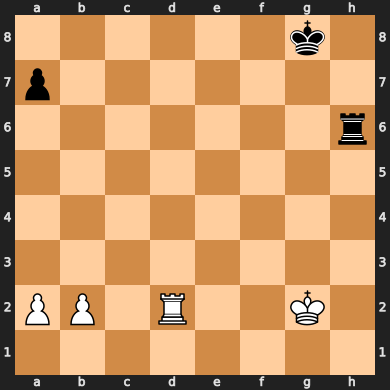

In [50]:
position = "kg8 pa7 rh6 Kg2 Rd2 Pb2 Pa2"

def decode_piece_position(pos):
    board = chess.Board()
    board.set_piece_map({chess.parse_square(term[1:]): chess.Piece.from_symbol(term[0]) for term in pos.strip().split(" ")})
    return board

display(decode_piece_position(position))

# kg8 pa7 rh6 Kg2 Rd2 Pb2 Pa2

# R<Pb2

### Observation
Up on attempting to pre process all 2 million games like this it became clear that this is not a feasible approach. As the full dataset took 300 GB of space. We believe that this was manly due to the overheard caused by creating a folder for each of the 2million games and a file for each of the board states. As such we decided to try and create a single file for all the games and put the state encoding on a single line.

#### Descent into Madness

##### New preprocessing script that puts position on a single file

In [ ]:

import os
import sys
import chess.pgn

NUM_MOVES_SKIP = 10  # Skip the first 12 moves of the games since these are usually theory

def a_closure(board):
    #FIXME: This ignores en passant attacks for now since they are a bit tricky
    t = board.turn
    
    board.turn = chess.WHITE
    w_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    w_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in w_capture_moves]

    board.turn = chess.BLACK
    b_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    b_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in b_capture_moves]

    board.turn = t
    return w_a_closure + b_a_closure

def d_closure(board):
    d_closure = []

    for square, piece in board.piece_map().items():
        if piece.piece_type != chess.KING: # Defending a king doesn't really make sense
            d_closure += [board.piece_at(x).symbol() + '<' + piece.symbol() + chess.square_name(square) for x in board.attackers(piece.color, square)]

    return d_closure

def p_closure(board):
    return [p.symbol()+chess.square_name(s) for s,p in board.piece_map().items()]


def main(pgn_file_path):
    num_games = 0

    # Open the PGN file
    with open(pgn_file_path) as pgn_file:
        game = chess.pgn.read_game(pgn_file)
        
        while game:
            num_games += 1
            
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            
            # Create the directory
            path = game.headers["Site"]
            id = path[path.rfind("/")+1:]
            dir_path = "./test/"
            
            # Loop over the game and generate the files in the directory
            move_counter = 0
            board = game.board()
            entries = str(game.headers) + "\n"
            for move in game.mainline_moves():
                move_counter += 1
                board.push(move)
                
                if move_counter > NUM_MOVES_SKIP:
                    entries += " ".join(p_closure(board))
                    entries += " ".join(a_closure(board))
                    entries += " ".join(d_closure(board))
                    entries += "\n"
                    # entries.append(" ".join(p_closure(board)) +"\n"+ " ".join(a_closure(board)) +"\n"+ " ".join(d_closure(board)))

            if entries:
                with open(dir_path + f"/{id}.txt", "w") as f:
                    f.write(entries)

            if num_games % 10 == 0:
                print(f"Processed {num_games} games so far...")
            
    print(f"The number of games in '{pgn_file_path}' is: {num_games}")

if __name__ == "__main__":
    if len(sys.argv) > 1:
        pgn_file_path = sys.argv[1]
        main(pgn_file_path)
    else:
        print("Please provide the path to the PGN file as an argument.")

##### Indexing in a new way

In [3]:
import sys, os, lucene, threading, time
from datetime import datetime
from java.nio.file import Paths
from org.apache.lucene.analysis.miscellaneous import LimitTokenCountAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer
from org.apache.lucene.document import Document, Field, FieldType
from org.apache.lucene.index import FieldInfo, IndexWriter, IndexWriterConfig, IndexOptions
from org.apache.lucene.store import NIOFSDirectory


class Ticker(object):
    def __init__(self):
        self.tick = True

    def run(self):
        while self.tick:
            sys.stdout.write('.')
            sys.stdout.flush()
            time.sleep(1.0)

class IndexFiles(object):
    def __init__(self, root, storeDir, analyzer):
        if not os.path.exists(storeDir):
            os.mkdir(storeDir)

        store = NIOFSDirectory(Paths.get(storeDir))
        analyzer = LimitTokenCountAnalyzer(analyzer, 1048576)
        config = IndexWriterConfig(analyzer)
        config.setOpenMode(IndexWriterConfig.OpenMode.CREATE)
        writer = IndexWriter(store, config)

        self.indexDocs(root, writer)
        ticker = Ticker()
        print ('commit index'),
        threading.Thread(target=ticker.run).start()
        writer.commit()
        writer.close()
        ticker.tick = False
        print ('done')

    def indexDocs(self, root, writer):
        t1 = FieldType()
        t1.setStored(True)
        t1.setTokenized(False)
        t1.setIndexOptions(IndexOptions.DOCS_AND_FREQS)

        t2 = FieldType()
        t2.setStored(False)
        t2.setTokenized(True)
        t2.setIndexOptions(IndexOptions.DOCS_AND_FREQS_AND_POSITIONS) # TODO: This might be overkill

        for root, dirnames, filenames in os.walk(root):
            for filename in filenames:
                if not filename.endswith('.txt'):
                    continue
                # print ("adding", filename)
                try:
                    path = os.path.join(root, filename)
                    with open(path, 'r') as file:
                        line_count = 10
                        for line in file:
                            contents = str(line)
                            doc = Document()
                            doc.add(Field("game", filename, t1))
                            doc.add(Field("move", line_count, t1))   

                            if len(contents) > 0:
                                doc.add(Field("contents", contents, t2))
                            else:
                                print ("warning: no content in %s" % filename)
                            writer.addDocument(doc)
                            line_count += 1
                except Exception as e:
                    print ("Failed in indexDocs:", e)

start = datetime.now()
try:
    IndexFiles("./test/", "./test.index", WhitespaceAnalyzer())
except Exception as e:
    print ("Failed: ", e)
    raise e
end = datetime.now()
print (end - start)

commit index
.done
0:00:00.786312


In [6]:
from java.nio.file import Paths
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import NIOFSDirectory
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.search.similarities import BM25Similarity

def run(searcher, analyzer, command):
    print ("Searching for:", command)
    escaped_command = command.replace("/", "\\/")
    query = QueryParser("contents", analyzer).parse(escaped_command)
    scoreDocs = searcher.search(query, 10).scoreDocs
    print ("%s total matching documents." % len(scoreDocs))

    for scoreDoc in scoreDocs:        
        doc = searcher.doc(scoreDoc.doc)
        print(doc.get("game"))
        print(doc.get("move"))
        # path = os.path.join(doc.get("game"), doc.get("name"))
        # file = open(path)
        # content = str(file.read())
        # file.close()
        
        # print (scoreDoc.score)
        # print(path)
        # print(set(content.split(" ")) & set(command.split(" ")))
        # print(len(content.split(" ")))

directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
searcher.setSimilarity(BM25Similarity())
analyzer = WhitespaceAnalyzer()

run(searcher, analyzer, command="pa5")
del searcher

Searching for: pa5
10 total matching documents.
0soyDIjv.txt
95
0soyDIjv.txt
96
6b8IDGjH.txt
53
0soyDIjv.txt
83
0soyDIjv.txt
90
0soyDIjv.txt
91
0soyDIjv.txt
94
6b8IDGjH.txt
51
6b8IDGjH.txt
52
0soyDIjv.txt
82


#### Testing if the new approach works

In [3]:
import chess.pgn 

# LOGIC TO ENCODE THE BOARD
val_map = {i: str(1 - (7 * i / 64)) for i in range(1, 9)}
# TODO: Not yet hyper optimized
def r_closure(board):
    t = board.turn
    board.turn = chess.WHITE
    w_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move)]
    w_r_closure = [board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)] for x in w_none_capture_moves]

    board.turn = chess.BLACK
    b_none_capture_moves = [move for move in board.legal_moves if not board.is_capture(move)]
    b_r_closure = [board.piece_at(x.from_square).symbol() + chess.square_name(x.to_square) + '^' + val_map[chess.square_distance(x.from_square, x.to_square)] for x in b_none_capture_moves]

    board.turn = t
    return w_r_closure + b_r_closure

# Logic to calculate the representation 
def a_closure(board):
    #FIXME: This ignores en passant attacks for now since they are a bit tricky
    t = board.turn
    
    board.turn = chess.WHITE
    w_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    w_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in w_capture_moves]

    board.turn = chess.BLACK
    b_capture_moves = [move for move in board.legal_moves if board.is_capture(move) and not board.is_en_passant(move)]
    b_a_closure = [board.piece_at(x.from_square).symbol() + ">" + board.piece_at(x.to_square).symbol() + chess.square_name(x.to_square) for x in b_capture_moves]

    board.turn = t
    return w_a_closure + b_a_closure

def d_closure(board):
    d_closure = []

    for square, piece in board.piece_map().items():
        if piece.piece_type != chess.KING: # Defending a king doesn't really make sense
            d_closure += [board.piece_at(x).symbol() + '<' + piece.symbol() + chess.square_name(square) for x in board.attackers(piece.color, square)]

    return d_closure

def p_closure(board):
    return [p.symbol()+chess.square_name(s) for s,p in board.piece_map().items()]

def encode_board_position(board):
    return  " ".join(r_closure(board)) + " " + " ".join(p_closure(board)) +" "+ " ".join(a_closure(board)) +" "+ " ".join(d_closure(board))

# LOGIC TO DECODE THE BOARD
def decode_piece_position(pos):
    board = chess.Board()
    board.set_piece_map({chess.parse_square(term[1:]): chess.Piece.from_symbol(term[0]) for term in pos.strip().split(" ")})
    return board


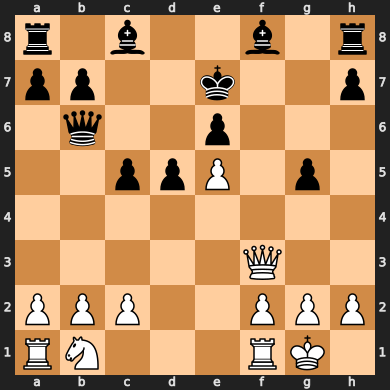

In [5]:
# Looking up exact positions

# From: https://lichess.org/ZrQX4bnu#26
fen_pos = "r1b2b1r/pp2k2p/1q2p3/2ppP1p1/8/5Q2/PPP2PPP/RN3RK1 w - - 1 14"

board = chess.Board(fen_pos)
display(board)

In [7]:
encoding = encode_board_position(board)
print(len(encoding))
print(encoding)

<built-in function len>
Qf7^0.5625 Qf6^0.671875 Qh5^0.78125 Qf5^0.78125 Qg4^0.890625 Qf4^0.890625 Qe4^0.890625 Qh3^0.78125 Qg3^0.890625 Qe3^0.890625 Qd3^0.78125 Qc3^0.671875 Qb3^0.5625 Qa3^0.453125 Qe2^0.890625 Qd1^0.78125 Kh1^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Nc3^0.78125 Na3^0.78125 Nd2^0.78125 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Pa3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 Pa4^0.78125 rg8^0.890625 bg7^0.890625 bh6^0.78125 bd7^0.890625 rb8^0.890625 ke8^0.890625 kd8^0.890625 kd7^0.890625 qd8^0.78125 qc7^0.890625 qd6^0.78125 qc6^0.890625 qa6^0.890625 qb5^0.890625 qa5^0.890625 qb4^0.78125 qb3^0.671875 ph6^0.890625 pa6^0.890625 pg4^0.890625 pd4^0.890625 pc4^0.890625 ph5^0.78125 pa5^0.78125 rh8 bf8 bc8 ra8 ph7 ke7 pb7 pa7 pe6 qb6 pg5 Pe5 pd5 pc5 Qf3 Ph2 Pg2 Pf2 Pc2 Pb2 Pa2 Kg1 Rf1 Nb1 Ra1 Q>bf8 Q>pd5 q>Pb2 k<bf8 r<bf8 r<bc8 r<ph7 q<pb7 b<pb7 q<pa7 r<pa7 q<pe6 k<pe6 b<pe6 p<qb6 p<pd5 q<pc5 P<Qf3 K<Ph2 K<Pg2 Q<Pg2 R<Pf2 K<Pf2 Q<Pf2 R<Pa2 K<Rf1 R<N

Searching for: Qf7^0.5625 Qf6^0.671875 Qh5^0.78125 Qf5^0.78125 Qg4^0.890625 Qf4^0.890625 Qe4^0.890625 Qh3^0.78125 Qg3^0.890625 Qe3^0.890625 Qd3^0.78125 Qc3^0.671875 Qb3^0.5625 Qa3^0.453125 Qe2^0.890625 Qd1^0.78125 Kh1^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Nc3^0.78125 Na3^0.78125 Nd2^0.78125 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Pa3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 Pa4^0.78125 rg8^0.890625 bg7^0.890625 bh6^0.78125 bd7^0.890625 rb8^0.890625 ke8^0.890625 kd8^0.890625 kd7^0.890625 qd8^0.78125 qc7^0.890625 qd6^0.78125 qc6^0.890625 qa6^0.890625 qb5^0.890625 qa5^0.890625 qb4^0.78125 qb3^0.671875 ph6^0.890625 pa6^0.890625 pg4^0.890625 pd4^0.890625 pc4^0.890625 ph5^0.78125 pa5^0.78125 rh8 bf8 bc8 ra8 ph7 ke7 pb7 pa7 pe6 qb6 pg5 Pe5 pd5 pc5 Qf3 Ph2 Pg2 Pf2 Pc2 Pb2 Pa2 Kg1 Rf1 Nb1 Ra1 Q>bf8 Q>pd5 q>Pb2 k<bf8 r<bf8 r<bc8 r<ph7 q<pb7 b<pb7 q<pa7 r<pa7 q<pe6 k<pe6 b<pe6 p<qb6 p<pd5 q<pc5 P<Qf3 K<Ph2 K<Pg2 Q<Pg2 R<Pf2 K<Pf2 Q<Pf2 R<Pa2 K<Rf1 R<Nb1 R<Nb1


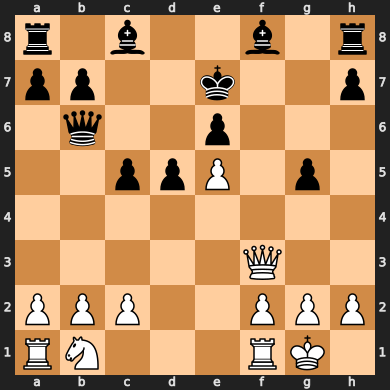

- Also found ZrQX4bnu.txt at position 27 with score 41.21630859375
- Also found ZrQX4bnu.txt at position 28 with score 38.67072296142578
- Also found ZrQX4bnu.txt at position 25 with score 33.87632369995117
- Also found ZrQX4bnu.txt at position 29 with score 33.832664489746094
- Also found ZrQX4bnu.txt at position 23 with score 33.66586685180664
- Also found ZrQX4bnu.txt at position 24 with score 32.63582992553711
- Also found ZrQX4bnu.txt at position 30 with score 32.22661590576172
- Also found ZrQX4bnu.txt at position 31 with score 32.147308349609375
- Also found ZrQX4bnu.txt at position 32 with score 30.903261184692383
- Also found ZrQX4bnu.txt at position 33 with score 27.11128044128418
- Also found ZrQX4bnu.txt at position 35 with score 26.02481460571289
- Also found ZrQX4bnu.txt at position 22 with score 25.69701385498047
- Also found ZrQX4bnu.txt at position 34 with score 24.816890716552734
vCjln3Ux.txt
26
24.450366973876953


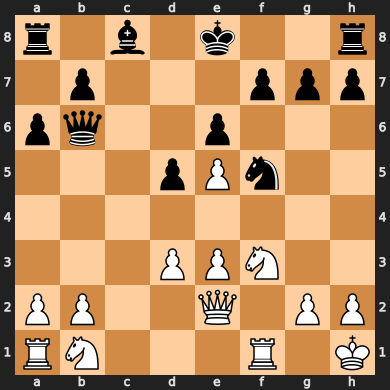

- Also found vCjln3Ux.txt at position 27 with score 23.712295532226562
- Also found ZrQX4bnu.txt at position 21 with score 23.484317779541016
- Also found ZrQX4bnu.txt at position 20 with score 23.351659774780273
- Also found ZrQX4bnu.txt at position 36 with score 22.522201538085938
- Also found vCjln3Ux.txt at position 28 with score 22.518644332885742


In [31]:
PATH = "./test/"

import os
from java.nio.file import Paths
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import NIOFSDirectory
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.analysis.core import WhitespaceAnalyzer

def run(searcher, analyzer, command):
    print ("Searching for:", command)
    escaped_command = command.replace("/", "\\/")
    query = QueryParser("contents", analyzer).parse(escaped_command)
    scoreDocs = searcher.search(query, 20).scoreDocs
    print ("%s total matching documents." % len(scoreDocs))

    seen_games = set()
    
    for scoreDoc in scoreDocs:
        doc = searcher.doc(scoreDoc.doc)
        
        if doc.get("game") in seen_games:
            print(f"- Also found {doc.get('game')} at position {doc.get('move')} with score {scoreDoc.score}")
            continue
               
        print(doc.get("game"))
        print(doc.get("move"))
        print(scoreDoc.score)
        
        file = open(os.path.join(PATH, doc.get("game")))
        content = str(file.read()).split("\n")[int(doc.get("move"))-10].split("|")[0]
        display(decode_piece_position(content))
        file.close()
        
        seen_games.add(doc.get("game"))

directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
searcher.setSimilarity(BM25Similarity())
analyzer = WhitespaceAnalyzer()

run(searcher, analyzer, command=encoding)
del searcher

#### Observation
Seems to work but we also see that there are multiple matches for the same game which is not what we want. We want to have a single match for each game. So let us try to fix that.  
We can now see that there is a second document matched that is somewhat similar to the first one. It is not perfect obviously due to the small size of the dataset but it is a good POC.

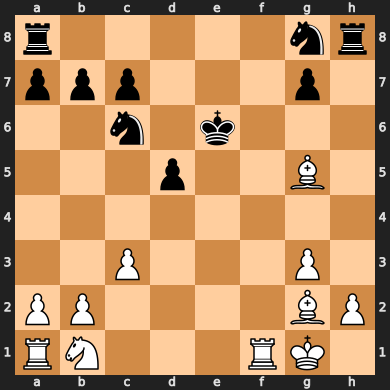

Searching for: Bd8^0.671875 Be7^0.78125 Bh6^0.890625 Bf6^0.890625 Bh4^0.890625 Bf4^0.890625 Be3^0.78125 Bd2^0.671875 Bc1^0.5625 Be4^0.78125 Bh3^0.890625 Bf3^0.890625 Bh1^0.890625 Kf2^0.890625 Kh1^0.890625 Rf8^0.234375 Rf7^0.34375 Rf6^0.453125 Rf5^0.5625 Rf4^0.671875 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Na3^0.78125 Nd2^0.78125 Pg4^0.890625 Pc4^0.890625 Ph3^0.890625 Pb3^0.890625 Pa3^0.890625 Ph4^0.78125 Pb4^0.78125 Pa4^0.78125 rh7^0.890625 rh6^0.78125 rh5^0.671875 rh4^0.5625 rh3^0.453125 ne7^0.78125 nh6^0.78125 nf6^0.78125 rf8^0.453125 re8^0.5625 rd8^0.671875 rc8^0.78125 rb8^0.890625 kd7^0.890625 kd6^0.890625 ke5^0.890625 nd8^0.78125 nb8^0.78125 ne7^0.78125 ne5^0.78125 na5^0.78125 nd4^0.78125 nb4^0.78125 pg6^0.890625 pb6^0.890625 pa6^0.890625 pd4^0.890625 pb5^0.78125 pa5^0.78125 rh8 ng8 ra8 pg7 pc7 pb7 pa7 ke6 nc6 Bg5 pd5 Pg3 Pc3 Ph2 Bg2 Pb2 Pa2 Kg1 Rf1 Nb1 Ra1 B>pd5 r>Ph2 r<ng8 r<ng8 n<pa7 r<pa7 p<nc6 k<pd5 P<Pg3 N<Pc3 P<Pc3 K<Ph2 K<Bg2 R<Pa2 K<Rf1 B<Rf1 R<Nb1 

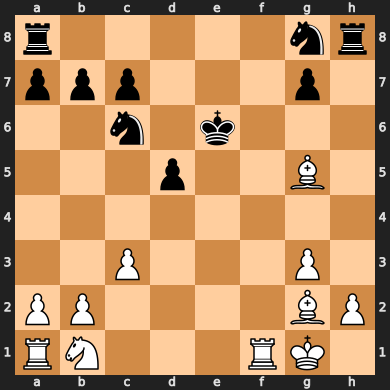

- Also found drwaxXe4.txt at position 33 with score 33.40001678466797
- Also found drwaxXe4.txt at position 32 with score 31.206708908081055
- Also found drwaxXe4.txt at position 35 with score 30.500640869140625
- Also found drwaxXe4.txt at position 36 with score 28.960277557373047
- Also found drwaxXe4.txt at position 37 with score 28.37433433532715
- Also found drwaxXe4.txt at position 26 with score 26.866666793823242
- Also found drwaxXe4.txt at position 27 with score 26.866666793823242
- Also found drwaxXe4.txt at position 28 with score 26.866666793823242
- Also found drwaxXe4.txt at position 31 with score 26.552227020263672
- Also found drwaxXe4.txt at position 30 with score 26.41905403137207
- Also found drwaxXe4.txt at position 25 with score 25.315093994140625
- Also found drwaxXe4.txt at position 41 with score 25.2863826751709
- Also found drwaxXe4.txt at position 29 with score 25.20260238647461
- Also found drwaxXe4.txt at position 38 with score 25.066123962402344
- Also found

In [32]:
# From: https://lichess.org/drwaxXe4#34
fen_pos = "r5nr/ppp3p1/2n1k3/3p2B1/8/2P3P1/PP4BP/RN3RK1"
board = chess.Board(fen_pos)
display(board)

directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
searcher.setSimilarity(BM25Similarity())
analyzer = WhitespaceAnalyzer()

run(searcher, analyzer, command=encode_board_position(board))
del searcher

#### Look for altered boarded

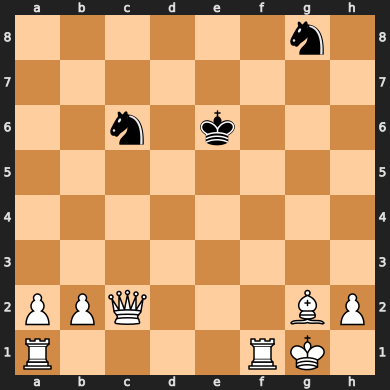

Searching for: Bd5^0.671875 Be4^0.78125 Bh3^0.890625 Bf3^0.890625 Bh1^0.890625 Qh7^0.453125 Qg6^0.5625 Qf5^0.671875 Qc5^0.671875 Qe4^0.78125 Qc4^0.78125 Qa4^0.78125 Qd3^0.890625 Qc3^0.890625 Qb3^0.890625 Qf2^0.671875 Qe2^0.78125 Qd2^0.890625 Qd1^0.890625 Qc1^0.890625 Qb1^0.890625 Kf2^0.890625 Kh1^0.890625 Rf8^0.234375 Rf7^0.34375 Rf6^0.453125 Rf5^0.5625 Rf4^0.671875 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Rb1^0.5625 Re1^0.5625 Rd1^0.671875 Rc1^0.78125 Rb1^0.890625 Ph3^0.890625 Pb3^0.890625 Pa3^0.890625 Ph4^0.78125 Pb4^0.78125 Pa4^0.78125 ne7^0.78125 nh6^0.78125 nf6^0.78125 ke7^0.890625 kd7^0.890625 kd6^0.890625 ke5^0.890625 nd8^0.78125 nb8^0.78125 ne7^0.78125 na7^0.78125 ne5^0.78125 na5^0.78125 nd4^0.78125 nb4^0.78125 ng8 ke6 nc6 Ph2 Bg2 Qc2 Pb2 Pa2 Kg1 Rf1 Ra1 B>nc6 Q>nc6 K<Ph2 K<Bg2 Q<Bg2 Q<Pb2 R<Pa2 R<Rf1 K<Rf1 B<Rf1 R<Ra1
20 total matching documents.
drwaxXe4.txt
36
15.619277954101562


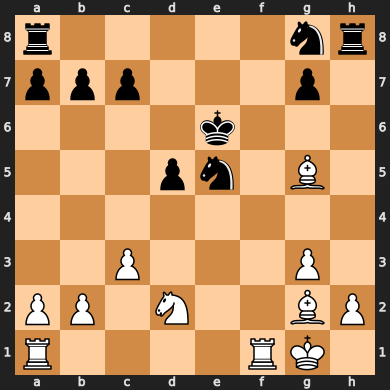

- Also found drwaxXe4.txt at position 35 with score 15.118319511413574
- Also found drwaxXe4.txt at position 37 with score 13.785868644714355
- Also found drwaxXe4.txt at position 34 with score 12.920957565307617
- Also found drwaxXe4.txt at position 23 with score 12.788178443908691
- Also found drwaxXe4.txt at position 42 with score 12.687606811523438
- Also found drwaxXe4.txt at position 38 with score 12.676613807678223
- Also found drwaxXe4.txt at position 24 with score 12.57512092590332
- Also found drwaxXe4.txt at position 39 with score 12.450332641601562
- Also found drwaxXe4.txt at position 33 with score 12.312990188598633
- Also found drwaxXe4.txt at position 41 with score 12.217884063720703
- Also found drwaxXe4.txt at position 32 with score 12.197962760925293
- Also found drwaxXe4.txt at position 40 with score 11.575079917907715
VHpl3CXA.txt
37
11.517983436584473


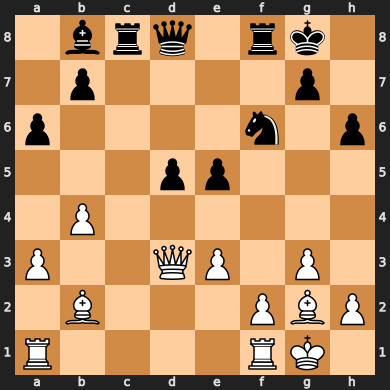

- Also found drwaxXe4.txt at position 25 with score 11.511943817138672
nkerfwVx.txt
30
11.443373680114746


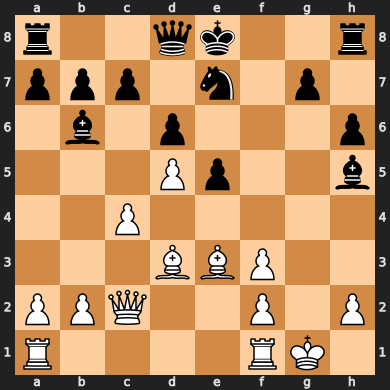

- Also found drwaxXe4.txt at position 26 with score 11.350563049316406
- Also found drwaxXe4.txt at position 27 with score 11.350563049316406
- Also found drwaxXe4.txt at position 28 with score 11.350563049316406
- Also found VHpl3CXA.txt at position 38 with score 11.15816879272461


In [33]:
# From: https://lichess.org/drwaxXe4#34
fen_pos = "6n1/8/2n1k3/8/8/8/PPQ3BP/R4RK1 w - - 0 18"
board = chess.Board(fen_pos)
display(board)

directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
searcher.setSimilarity(BM25Similarity())
analyzer = WhitespaceAnalyzer()

run(searcher, analyzer, command=encode_board_position(board))
del searcher

#### Observation
We can see that the similarity measure is low (due to the small size of the dataset) but it does manage to find the position that the altered board is based on as well as some other positions that do share some similarities.

## Indexing (250k games)
Let us try and index the subset of 250k games.

In [2]:
import sys, os, lucene, time
from datetime import datetime
from java.nio.file import Paths
from org.apache.lucene.analysis.miscellaneous import LimitTokenCountAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer
from org.apache.lucene.document import Document, Field, FieldType
from org.apache.lucene.index import FieldInfo, IndexWriter, IndexWriterConfig, IndexOptions
from org.apache.lucene.store import NIOFSDirectory


class IndexFiles(object):
    def __init__(self, root, storeDir, analyzer):
        if not os.path.exists(storeDir):
            os.mkdir(storeDir)

        store = NIOFSDirectory(Paths.get(storeDir))
        analyzer = LimitTokenCountAnalyzer(analyzer, 1048576)
        config = IndexWriterConfig(analyzer)
        config.setOpenMode(IndexWriterConfig.OpenMode.CREATE)
        writer = IndexWriter(store, config)

        self.indexDocs(root, writer)
        print ('commit index'),
        writer.commit()
        writer.close()
        print ('done')

    def indexDocs(self, root, writer):
        t1 = FieldType()
        t1.setStored(True)
        t1.setTokenized(False)
        t1.setIndexOptions(IndexOptions.DOCS_AND_FREQS)

        t2 = FieldType()
        t2.setStored(False)
        t2.setTokenized(True)
        t2.setIndexOptions(IndexOptions.DOCS_AND_FREQS_AND_POSITIONS) # TODO: This might be overkill

        for root, dirnames, filenames in os.walk(root):
            for filename in filenames:
                if not filename.endswith('.txt'):
                    continue
                
                try:
                    path = os.path.join(root, filename)
                    with open(path, 'r') as file:
                        line_count = 10
                        for line in file:
                            contents = str(line)
                            doc = Document()
                            doc.add(Field("game", filename, t1))
                            doc.add(Field("move", line_count, t1))   

                            if len(contents) > 0:
                                doc.add(Field("contents", contents, t2))
                            else:
                                print ("warning: no content in %s" % filename)
                            writer.addDocument(doc)
                            line_count += 1
                except Exception as e:
                    print ("Failed in indexDocs:", e)

start = datetime.now()
try:
    IndexFiles("./games/", "./games.index", WhitespaceAnalyzer())
except Exception as e:
    print ("Failed: ", e)
    raise e
end = datetime.now()
print (end - start)

commit index
done
0:06:55.777121


## Querying
Let us try and query the index with some positions.

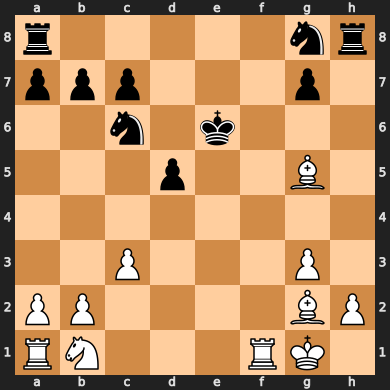

Searching for: Bd8^0.671875 Be7^0.78125 Bh6^0.890625 Bf6^0.890625 Bh4^0.890625 Bf4^0.890625 Be3^0.78125 Bd2^0.671875 Bc1^0.5625 Be4^0.78125 Bh3^0.890625 Bf3^0.890625 Bh1^0.890625 Kf2^0.890625 Kh1^0.890625 Rf8^0.234375 Rf7^0.34375 Rf6^0.453125 Rf5^0.5625 Rf4^0.671875 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Na3^0.78125 Nd2^0.78125 Pg4^0.890625 Pc4^0.890625 Ph3^0.890625 Pb3^0.890625 Pa3^0.890625 Ph4^0.78125 Pb4^0.78125 Pa4^0.78125 rh7^0.890625 rh6^0.78125 rh5^0.671875 rh4^0.5625 rh3^0.453125 ne7^0.78125 nh6^0.78125 nf6^0.78125 rf8^0.453125 re8^0.5625 rd8^0.671875 rc8^0.78125 rb8^0.890625 kd7^0.890625 kd6^0.890625 ke5^0.890625 nd8^0.78125 nb8^0.78125 ne7^0.78125 ne5^0.78125 na5^0.78125 nd4^0.78125 nb4^0.78125 pg6^0.890625 pb6^0.890625 pa6^0.890625 pd4^0.890625 pb5^0.78125 pa5^0.78125 rh8 ng8 ra8 pg7 pc7 pb7 pa7 ke6 nc6 Bg5 pd5 Pg3 Pc3 Ph2 Bg2 Pb2 Pa2 Kg1 Rf1 Nb1 Ra1 B>pd5 r>Ph2 r<ng8 r<ng8 n<pa7 r<pa7 p<nc6 k<pd5 P<Pg3 N<Pc3 P<Pc3 K<Ph2 K<Bg2 R<Pa2 K<Rf1 B<Rf1 R<Nb1 

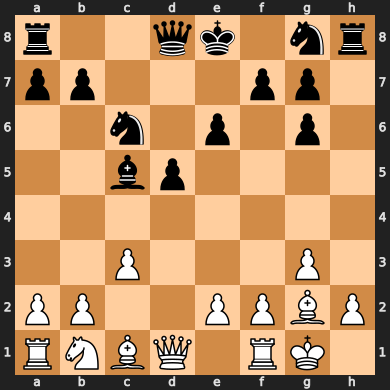

- Also found at match at position 18 with score 28.92337417602539 at https://lichess.org/c3lcFVVE#18
- Also found at match at position 21 with score 28.539073944091797 at https://lichess.org/c3lcFVVE#21
- Also found at match at position 20 with score 28.525426864624023 at https://lichess.org/c3lcFVVE#20

Game: ZnIWPxTI.txt
Move: 24
Link: https://lichess.org/ZnIWPxTI#24
Score: 28.343595504760742


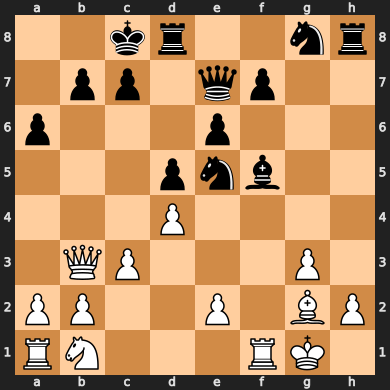

- Also found at match at position 25 with score 27.893991470336914 at https://lichess.org/ZnIWPxTI#25

Game: qsND9X68.txt
Move: 26
Link: https://lichess.org/qsND9X68#26
Score: 27.884126663208008


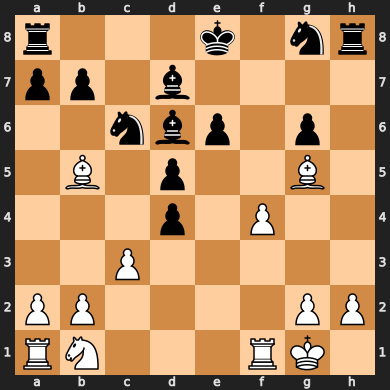

- Also found at match at position 19 with score 27.724407196044922 at https://lichess.org/c3lcFVVE#19

Game: xTBV3Xdu.txt
Move: 24
Link: https://lichess.org/xTBV3Xdu#24
Score: 27.676864624023438


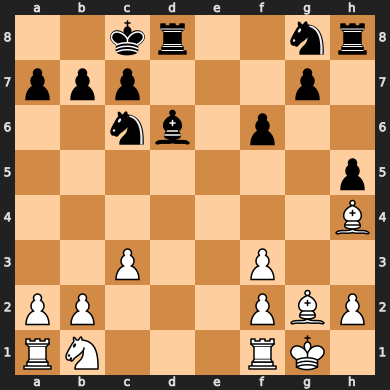


Game: bpoQTuwG.txt
Move: 19
Link: https://lichess.org/bpoQTuwG#19
Score: 27.622642517089844


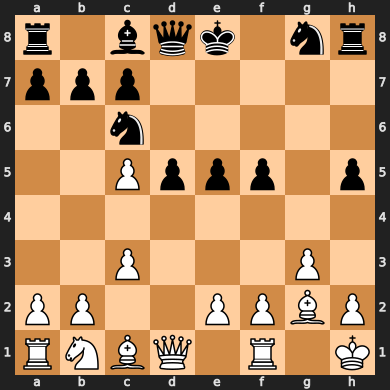

In [16]:
PATH = "./games/"

import os
from java.nio.file import Paths
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import NIOFSDirectory
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.analysis.core import WhitespaceAnalyzer

def run(searcher, analyzer, command, bound=10):
    print ("Searching for:", command)
    escaped_command = command.replace("/", "\\/")
    query = QueryParser("contents", analyzer).parse(escaped_command)
    scoreDocs = searcher.search(query, bound).scoreDocs
    print ("%s total matching documents." % len(scoreDocs))

    seen_games = set()
    
    for scoreDoc in scoreDocs:
        doc = searcher.doc(scoreDoc.doc)
        link = f"https://lichess.org/{doc.get('game').split('.')[0]}#{int(doc.get('move'))}"
        
        if doc.get("game") in seen_games:
            print(f"- Also found at match at position {doc.get('move')} with score {scoreDoc.score} at {link}")
            continue
        
        print()      
        print(f"Game: {doc.get('game')}")
        print(f"Move: {doc.get('move')}")
        print(f"Link: {link}")
        print(f"Score: {scoreDoc.score}")
        
        file = open(os.path.join(PATH, doc.get("game")))
        content = str(file.read()).split("\n")[int(doc.get("move"))-10].split("|")[0]
        display(decode_piece_position(content))
        file.close()
        
        seen_games.add(doc.get("game"))

directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/games.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
searcher.setSimilarity(BM25Similarity())
analyzer = WhitespaceAnalyzer()

# From: https://lichess.org/drwaxXe4#34
fen_pos = "r5nr/ppp3p1/2n1k3/3p2B1/8/2P3P1/PP4BP/RN3RK1"
board = chess.Board(fen_pos)
display(board)

run(searcher, analyzer, command=encode_board_position(board))
del searcher

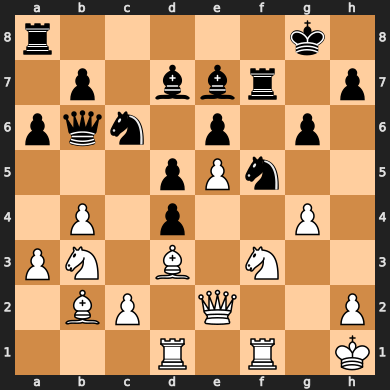

Searching for: Ng5^0.78125 Nh4^0.78125 Nd2^0.78125 Ng1^0.78125 Ne1^0.78125 Bb5^0.78125 Be4^0.890625 Bc4^0.890625 Nc5^0.78125 Na5^0.78125 Nd2^0.78125 Nc1^0.78125 Na1^0.78125 Qe4^0.78125 Qe3^0.890625 Qg2^0.78125 Qf2^0.890625 Qd2^0.890625 Qe1^0.890625 Bc3^0.890625 Bc1^0.890625 Ba1^0.890625 Kg2^0.890625 Kg1^0.890625 Rf2^0.890625 Rg1^0.890625 Re1^0.890625 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pg5^0.890625 Pb5^0.890625 Pa4^0.890625 Ph3^0.890625 Pc3^0.890625 Ph4^0.78125 Pc4^0.78125 kh8^0.890625 kf8^0.890625 kg7^0.890625 rf8^0.453125 re8^0.5625 rd8^0.671875 rc8^0.78125 rb8^0.890625 ra7^0.890625 rf8^0.890625 rg7^0.890625 rf6^0.890625 bf8^0.890625 bd8^0.890625 bf6^0.890625 bd6^0.890625 bg5^0.78125 bc5^0.78125 bh4^0.671875 be8^0.890625 bc8^0.890625 nd8^0.78125 nb8^0.78125 na7^0.78125 na5^0.78125 qd8^0.78125 qc7^0.890625 qa7^0.890625 qc5^0.890625 qb5^0.890625 qa5^0.890625 ng7^0.78125 nh6^0.78125 nd6^0.78125 nh4^0.78125 ng3^0.78125 ne3^0.78125 ph6^0.890625 pg5^0.890625 pa5

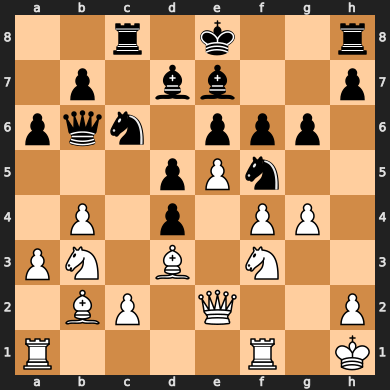

- Also found at match at position 27 with score 76.13082885742188 at https://lichess.org/O5Qaux1x#27
- Also found at match at position 28 with score 75.8465347290039 at https://lichess.org/O5Qaux1x#28
- Also found at match at position 25 with score 73.21395111083984 at https://lichess.org/O5Qaux1x#25
- Also found at match at position 26 with score 72.9034194946289 at https://lichess.org/O5Qaux1x#26
- Also found at match at position 24 with score 72.46691131591797 at https://lichess.org/O5Qaux1x#24
- Also found at match at position 33 with score 67.9877700805664 at https://lichess.org/O5Qaux1x#33
- Also found at match at position 34 with score 67.09662628173828 at https://lichess.org/O5Qaux1x#34
- Also found at match at position 30 with score 66.8131103515625 at https://lichess.org/O5Qaux1x#30
- Also found at match at position 23 with score 65.01197052001953 at https://lichess.org/O5Qaux1x#23
- Also found at match at position 31 with score 64.6627197265625 at https://lichess.org/O5Qaux1

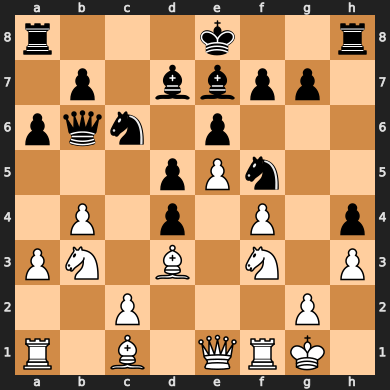

- Also found at match at position 32 with score 63.100772857666016 at https://lichess.org/O5Qaux1x#32
- Also found at match at position 32 with score 62.86842727661133 at https://lichess.org/tNcXAGvA#32

Game: PqZmNmuQ.txt
Move: 27
Link: https://lichess.org/PqZmNmuQ#27
Score: 62.80489730834961


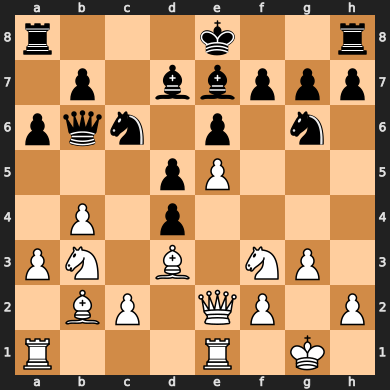

- Also found at match at position 29 with score 62.65015411376953 at https://lichess.org/tNcXAGvA#29

Game: R3jZRrcX.txt
Move: 21
Link: https://lichess.org/R3jZRrcX#21
Score: 62.54330825805664


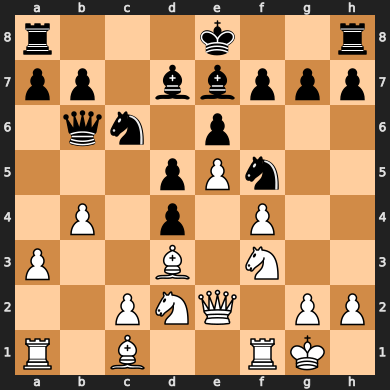

- Also found at match at position 27 with score 62.26698684692383 at https://lichess.org/tNcXAGvA#27
- Also found at match at position 28 with score 61.956451416015625 at https://lichess.org/tNcXAGvA#28
- Also found at match at position 20 with score 61.70479965209961 at https://lichess.org/R3jZRrcX#20


In [17]:
# Look up a position that we know is in the game

directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/games.index"))
searcher = IndexSearcher(DirectoryReader.open(directory))
searcher.setSimilarity(BM25Similarity())
analyzer = WhitespaceAnalyzer()

# From the game at: https://lichess.org/lP5hNZT7/white#34
# Puzzle: https://lichess.org/training/ZgxGl
line = "r5k1/1p1bbr1p/pqn1p1p1/3pPn2/1P1p2P1/PN1B1N2/1BP1Q2P/3R1R1K"
board = chess.Board(line)
display(board)

run(searcher, analyzer, command=encode_board_position(board), bound=20)
del searcher

# Stay Hungry Stay foolish
Querying is rather smooth so let us try and index the full 2 million games.

# Testing using the puzzles
The idea here is given a position check the state after all the possible moves against the DB the move that generates the "best" query result is selected as the chosen move and compared against the ground truth.
How the "best" query result is determined is still to be determined could be just taking the top@1 game of the sum of the top@5 games.

## Getting the Puzzels

In [19]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('lichess_db_puzzle.csv')

# Get the first 10 lines
first_10_lines = df.head(10)

# Print the first 10 lines
print(first_10_lines)

# Seems like we need to do some preprocessing


  PuzzleId                                                FEN  \
0    00008  r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...   
1    0000D  5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...   
2    0008Q       8/4R3/1p2P3/p4r2/P6p/1P3Pk1/4K3/8 w - - 1 64   
3    0009B  r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP...   
4    000Vc             8/8/4k1p1/2KpP2p/5PP1/8/8/8 w - - 0 53   
5    000Zo  4r3/1k6/pp3r2/1b2P2p/3R1p2/P1R2P2/1P4PP/6K1 w ...   
6    000aY  r4rk1/pp3ppp/2n1b3/q1pp2B1/8/P1Q2NP1/1PP1PP1P/...   
7    000hf  r1bqk2r/pp1nbNp1/2p1p2p/8/2BP4/1PN3P1/P3QP1P/3...   
8    000mr  5r1k/5rp1/p7/1b2B2p/1P1P1Pq1/2R1Q3/P3p1P1/2R3K...   
9    000rO          3R4/8/K7/pB2b3/1p6/1P2k3/3p4/8 w - - 4 58   

                           Moves  Rating  RatingDeviation  Popularity  \
0  f2g3 e6e7 b2b1 b3c1 b1c1 h6c1    1879               74          94   
1            d3d6 f8d8 d6d8 f6d8    1543               73          96   
2            e7f7 f5e5 e2f1 e5e6    1335               75        

In [20]:
print(df.shape)


(3625534, 10)


In [22]:
# Filter out games with a rating below 1500
filtered_df = df[df['Rating'] >= 1500]

# Print the shape of the filtered dataframe
print(filtered_df.shape)

(1792368, 10)


In [25]:
sorted_df = filtered_df.sort_values(by='Popularity')

sorted_df.head(1000).to_csv('sorted_df_output.csv', index=False)

2r2rk1/Qp1qbppp/4pn2/3p2B1/4PP2/P1N5/1PP3PP/3R1RK1 w - - 2 15


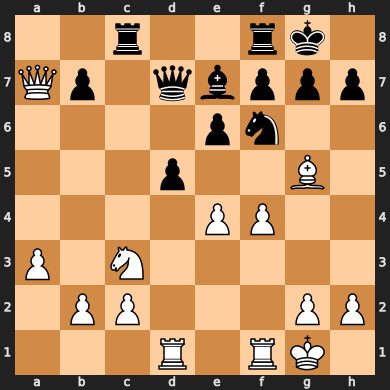

a7e3 e7c5 e3c5 c8c5


In [163]:
fen = sorted_df.iloc[0]['FEN']
print(fen)

board = chess.Board(fen)
display(board)

solution = sorted_df.iloc[0]['Moves']
print(solution)


a7b8
Searching for: Qa8^0.890625 Qc7^0.890625 Qa7^0.890625 Qd6^0.78125 Qe5^0.671875 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 Qb8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>rc8 Q>pb7 B>nf6 N>pd5 R>pd5 P>pd5 r>Qb8 r>Nc3 b>Pa3 n>Pe4 p>Pe4 b<rf8 r<rf8 k<rf8 q

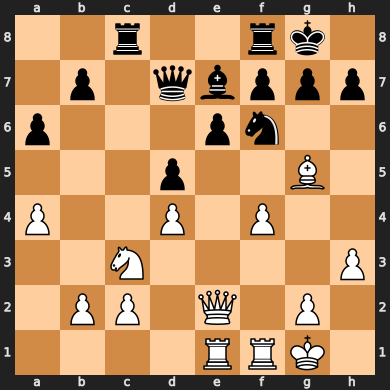

a7a8
Searching for: Qb8^0.890625 Qa7^0.890625 Qa6^0.78125 Qa5^0.671875 Qa4^0.5625 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 Qa8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>rc8 Q>pb7 B>nf6 N>pd5 R>pd5 P>pd5 r>Qa8 r>Nc3 b>Pa3 n>Pe4 p>Pe4 b<rf8 r<

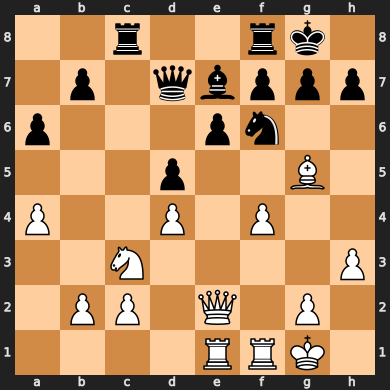

a7b7
Searching for: Qb8^0.890625 Qa8^0.890625 Qc7^0.890625 Qa7^0.890625 Qc6^0.890625 Qb6^0.890625 Qa6^0.890625 Qb5^0.78125 Qb4^0.671875 Qb3^0.5625 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 Qb7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>rc8 Q>qd7 Q>pd5 B>nf6 N>

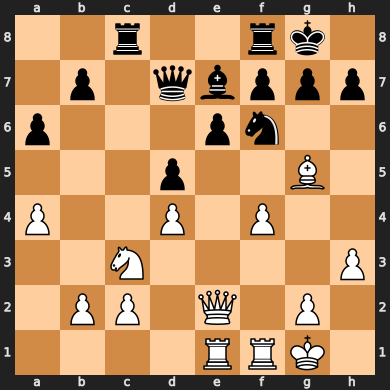

a7b6
Searching for: Qd8^0.78125 Qc7^0.890625 Qa7^0.890625 Qd6^0.78125 Qc6^0.890625 Qa6^0.890625 Qc5^0.890625 Qb5^0.890625 Qa5^0.890625 Qd4^0.78125 Qb4^0.78125 Qe3^0.671875 Qb3^0.671875 Qf2^0.5625 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Qb6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 P

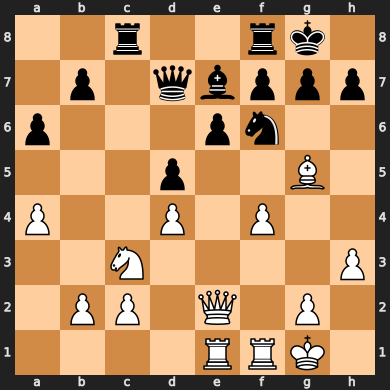

a7a6
Searching for: Qa8^0.78125 Qa7^0.890625 Qd6^0.671875 Qc6^0.78125 Qb6^0.890625 Qb5^0.890625 Qa5^0.890625 Qc4^0.78125 Qa4^0.78125 Qd3^0.671875 Qe2^0.5625 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Qa6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2

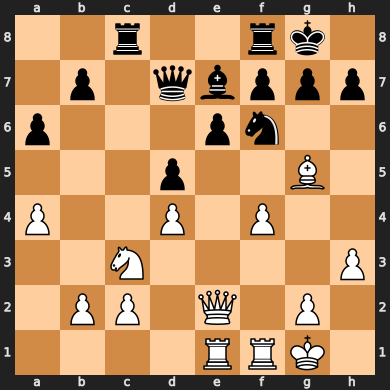

a7c5
Searching for: Bh6^0.890625 Bh4^0.890625 Qc7^0.78125 Qa7^0.78125 Qd6^0.890625 Qc6^0.890625 Qb6^0.890625 Qb5^0.890625 Qa5^0.78125 Qd4^0.890625 Qc4^0.890625 Qb4^0.890625 Qe3^0.78125 Qf2^0.671875 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 bd8^0.890625 bd6^0.890625 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Qc5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 B>nf6 Q>rc8 Q>be7 Q>p

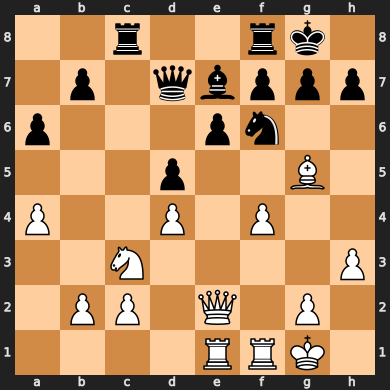

a7a5
Searching for: Bh6^0.890625 Bh4^0.890625 Qd8^0.671875 Qa8^0.671875 Qc7^0.78125 Qa7^0.78125 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qb5^0.890625 Qb4^0.890625 Qa4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Qa5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 R

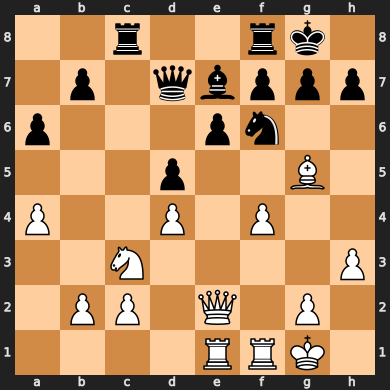

a7d4
Searching for: Bh6^0.890625 Bh4^0.890625 Qa7^0.671875 Qb6^0.78125 Qe5^0.890625 Qc5^0.890625 Qc4^0.890625 Qb4^0.78125 Qa4^0.671875 Qe3^0.890625 Qd3^0.890625 Qf2^0.78125 Qd2^0.78125 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Qd4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 B>nf6 Q>nf6

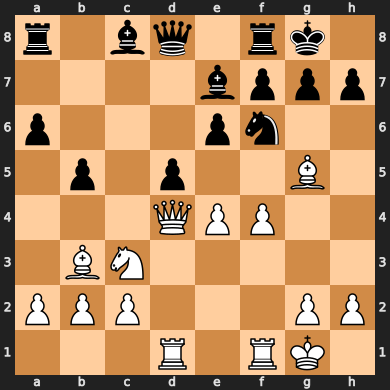

a7a4
Searching for: Bh6^0.890625 Bh4^0.890625 Qa8^0.5625 Qa7^0.671875 Qc6^0.78125 Qa6^0.78125 Qb5^0.890625 Qa5^0.890625 Qd4^0.671875 Qc4^0.78125 Qb4^0.890625 Qb3^0.890625 Nb5^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Qa4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 B>nf6 Q>qd7 N>pd5 R>pd5 P>pd5 r>Nc3 b

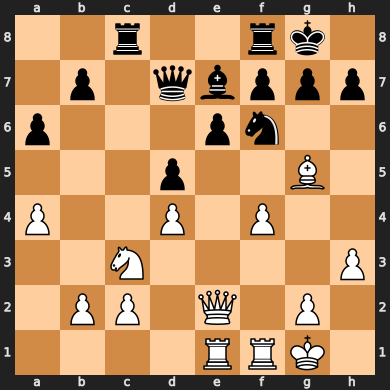

a7e3
Searching for: Bh6^0.890625 Bh4^0.890625 Qa7^0.5625 Qb6^0.671875 Qc5^0.78125 Qd4^0.890625 Qh3^0.671875 Qg3^0.78125 Qf3^0.890625 Qd3^0.890625 Qf2^0.890625 Qe2^0.890625 Qd2^0.890625 Qe1^0.78125 Qc1^0.78125 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Q

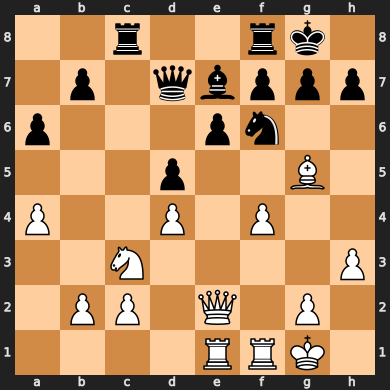

a7f2
Searching for: Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Qa7^0.453125 Qb6^0.5625 Qc5^0.671875 Qh4^0.78125 Qd4^0.78125 Qg3^0.890625 Qf3^0.890625 Qe3^0.890625 Qe2^0.890625 Qd2^0.78125 Qe1^0.890625 Kh1^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Qf2 Pc2 Pb2 Kg1 Rf1 Rd1 B>nf6 N>pd5 R>pd5 P>pd5 

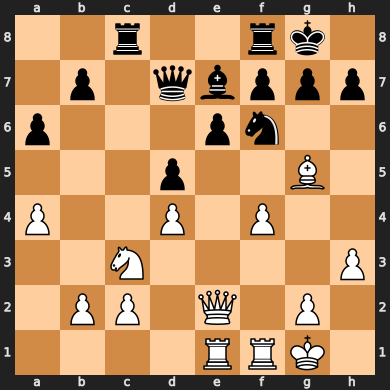

g5h6
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bg5^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 pg5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 Bh6 nf6 pe6 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>pb7 B>pg7 N>pd5 R>pd5 

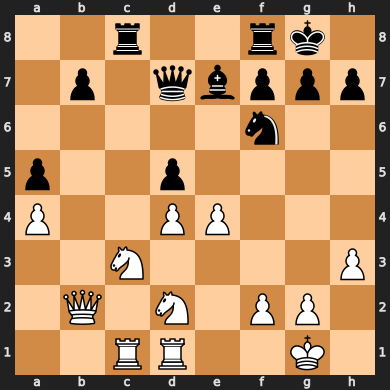

g5f6
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bg5^0.890625 Be5^0.890625 Bh4^0.78125 Bd4^0.78125 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pg5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 Bf6 pe6 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>

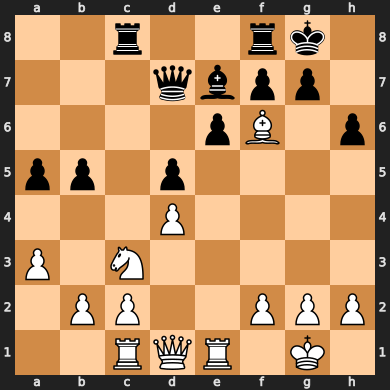

g5h4
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bg5^0.890625 Bg3^0.890625 Bf2^0.78125 Be1^0.671875 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pg5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 pd5 Bh4 Pf4 Pe4 Nc3 Pa3 P

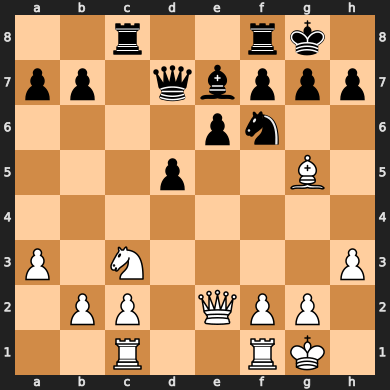

c3d5
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nc7^0.78125 Nb6^0.78125 Nb4^0.78125 Ne3^0.78125 Nc3^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 rc3^0.453125 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 Nd5 Pf4 Pe4 Pa3 Ph2 P

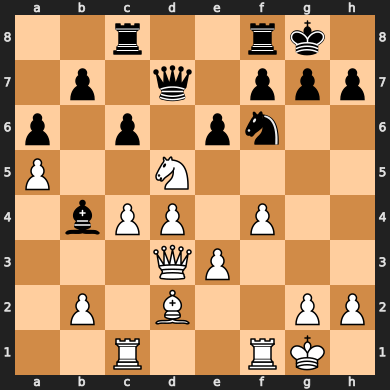

c3b5
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nc7^0.78125 Nd6^0.78125 Nd4^0.78125 Nc3^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 rc3^0.453125 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Nb5 Pf4 Pe4 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>pb7 B>n

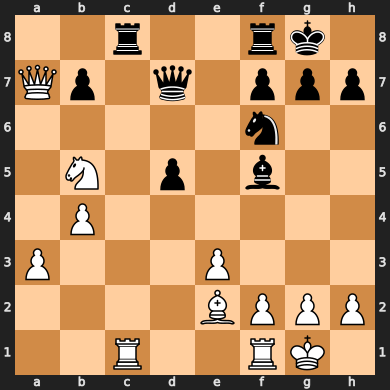

c3a4
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb6^0.78125 Nc5^0.78125 Nc3^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 rc3^0.453125 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Na4 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>pb7 B>nf6 R>pd5 P>pd5

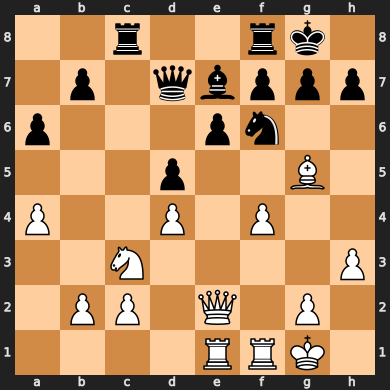

c3e2
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nd4^0.78125 Ng3^0.78125 Nc3^0.78125 Nc1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 rc3^0.453125 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Pa3 Ph2 

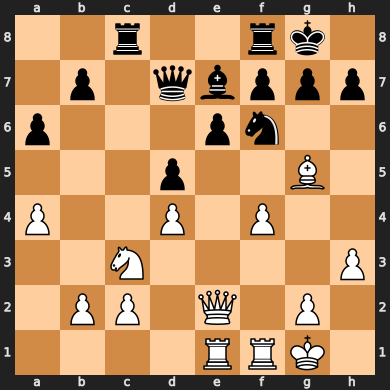

c3a2
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb4^0.78125 Nc3^0.78125 Nc1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 rc3^0.453125 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Pa3 Ph2 Pg2 Pc2 Pb2 

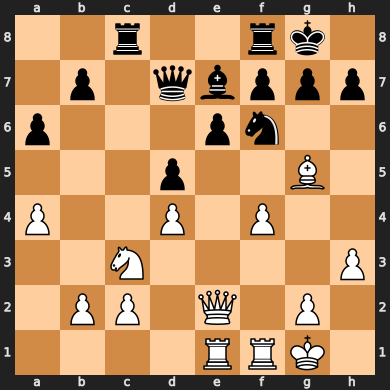

c3b1
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Nc3^0.78125 Nd2^0.78125 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pc3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pc4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 rc3^0.453125 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Nb1 Q>pb7 B>nf6 R>pd5 P>p

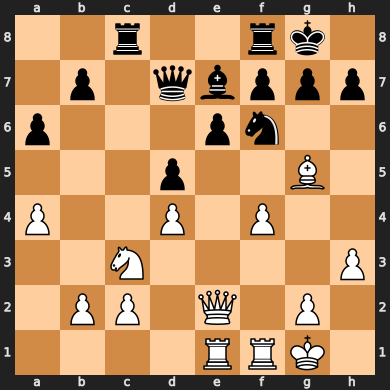

g1f2
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kg3^0.890625 Kf3^0.890625 Ke3^0.890625 Ke2^0.890625 Kg1^0.890625 Ke1^0.890625 Rh1^0.78125 Rg1^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4

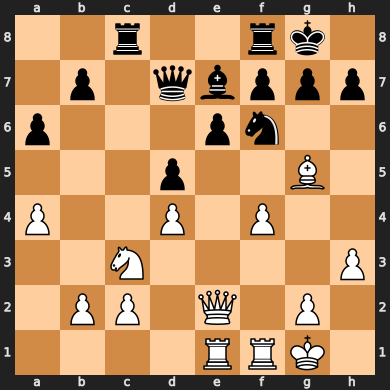

g1h1
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Qg1^0.34375 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kg1^0.890625 Rf3^0.78125 Rf2^0.890625 Rg1^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb

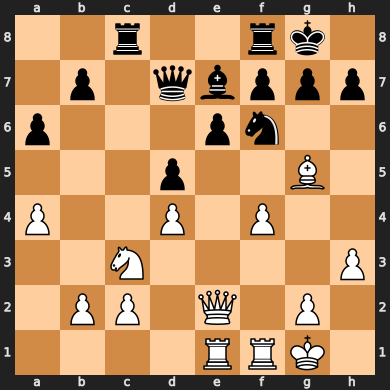

f1f3
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Rh3^0.78125 Rg3^0.890625 Re3^0.890625 Rd3^0.78125 Rf2^0.890625 Rf1^0.78125 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Kf1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Rf1^0.78125 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 

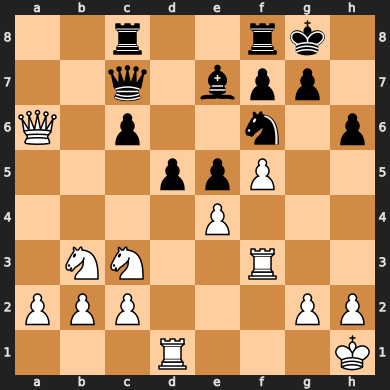

f1f2
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Rf3^0.890625 Re2^0.890625 Rd2^0.78125 Rf1^0.890625 Kh1^0.890625 Kf1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Rf1^0.78125 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Rf2 Pc

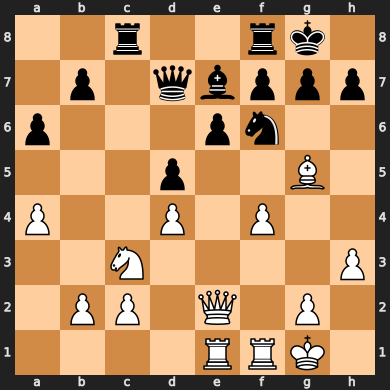

f1e1
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Kf1^0.890625 Re3^0.78125 Re2^0.890625 Rf1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Re1 Rd

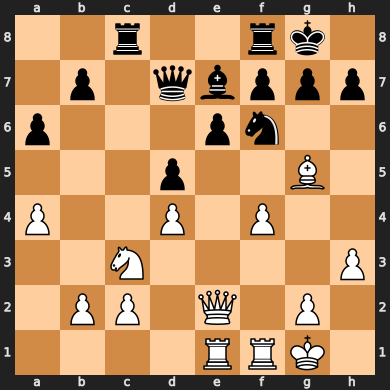

d1d5
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Rd6^0.890625 Rf5^0.78125 Re5^0.890625 Rc5^0.890625 Rb5^0.78125 Ra5^0.671875 Rd4^0.890625 Rd3^0.78125 Rd2^0.671875 Rd1^0.5625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Rb1^0.5625 Ra1^0.453125 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph

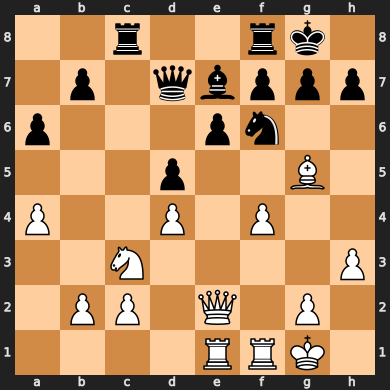

d1d4
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qa4^0.671875 Bh6^0.890625 Bh4^0.890625 Rc4^0.890625 Rb4^0.78125 Ra4^0.671875 Rd3^0.890625 Rd2^0.78125 Rd1^0.671875 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Rb1^0.5625 Ra1^0.453125 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Rd4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 

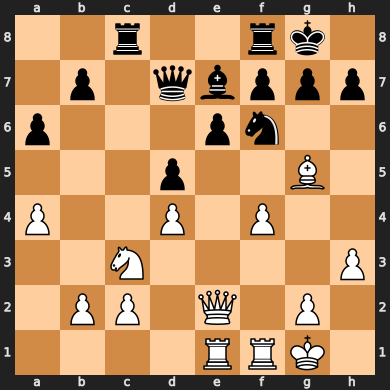

d1d3
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Rd4^0.890625 Rh3^0.5625 Rg3^0.671875 Rf3^0.78125 Re3^0.890625 Rd2^0.890625 Rd1^0.78125 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Rb1^0.5625 Ra1^0.453125 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7

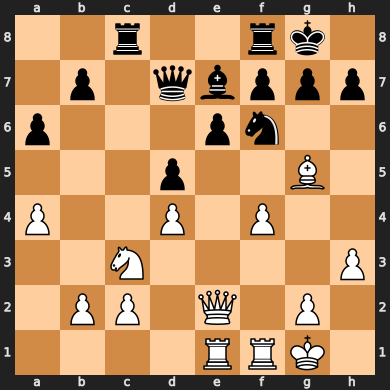

d1d2
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Nb1^0.78125 Rd4^0.78125 Rd3^0.890625 Rf2^0.78125 Re2^0.890625 Rd1^0.890625 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Rb1^0.5625 Ra1^0.453125 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4

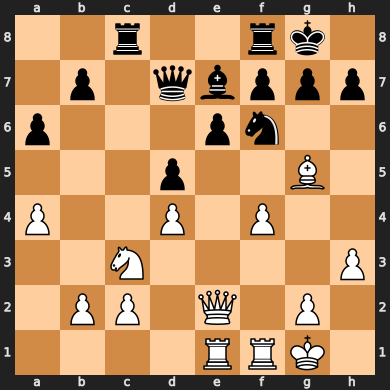

d1e1
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re3^0.78125 Re2^0.890625 Rd1^0.890625 Rc1^0.78125 Rb1^0.671875 Ra1^0.5625 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Re1 Q>pb7 B>nf6 N>

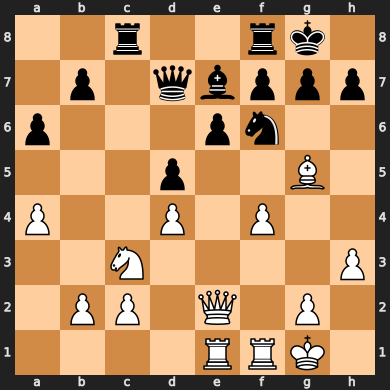

d1c1
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Re1^0.78125 Rd1^0.890625 Rb1^0.890625 Ra1^0.78125 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rc1 Q>pb7 B>nf6 N

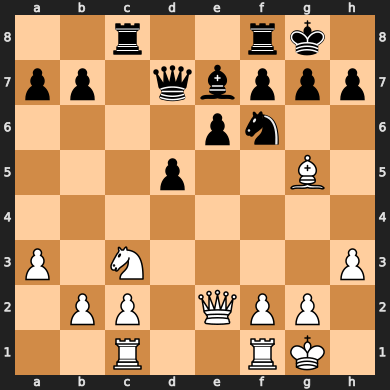

d1b1
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Re1^0.671875 Rd1^0.78125 Rc1^0.890625 Ra1^0.890625 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rb1 Q>pb7 B>nf6

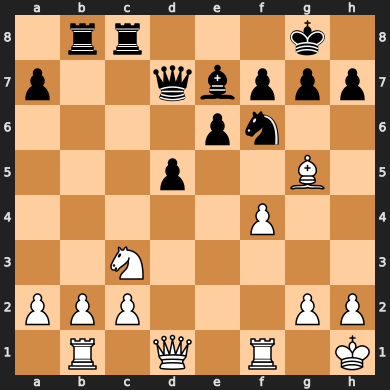

d1a1
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nd1^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd1^0.78125 Rc1^0.671875 Rb1^0.5625 Ra2^0.890625 Re1^0.5625 Rd1^0.671875 Rc1^0.78125 Rb1^0.890625 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pa3 Ph2 P

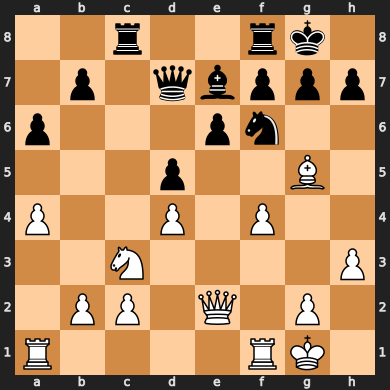

e4d5
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Ne4^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pd6^0.890625 Pf5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ne4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 Pd5 Pf4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1

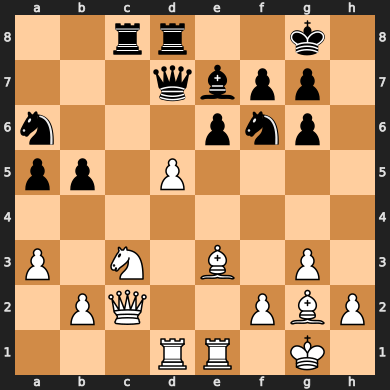

f4f5
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Bf4^0.890625 Be3^0.78125 Bd2^0.671875 Bc1^0.5625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf4^0.671875 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 B

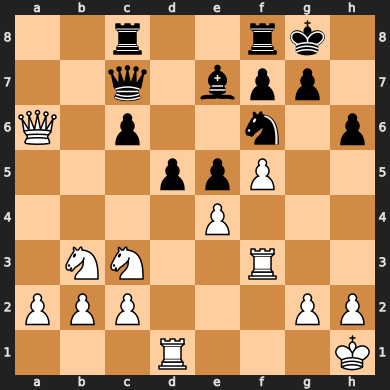

e4e5
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Ne4^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ne4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 Pe5 pd5 Pf4 Nc3 Pa3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 

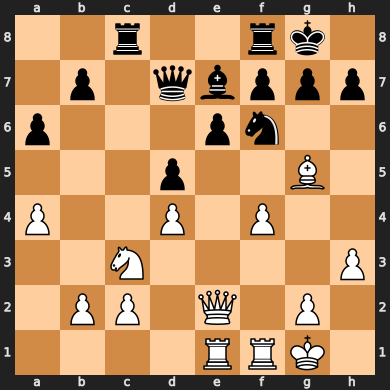

a3a4
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa5^0.890625 Ph3^0.890625 Pg3^0.890625 Pb3^0.890625 Ph4^0.78125 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 ba3^0.5625 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Pa4 Nc3 Ph2 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>pb7 B>nf6 N>pd5 R>pd5 P

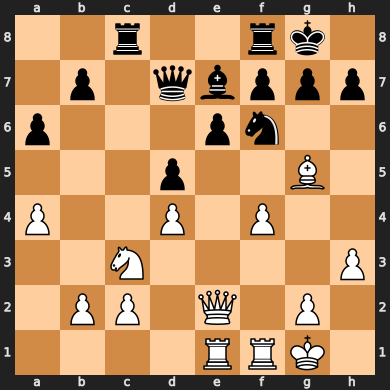

h2h3
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kh2^0.890625 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Ph4^0.890625 Pa4^0.890625 Pg3^0.890625 Pb3^0.890625 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Ph3 Nc3 Pa3 Pg2 Pc2 Pb2 Kg1 Rf1 R

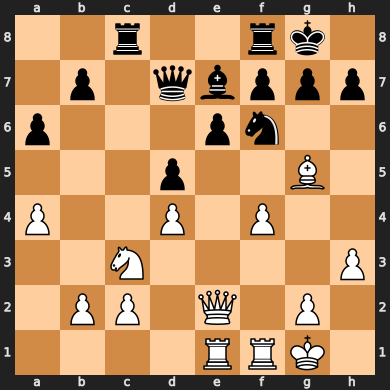

g2g3
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kg2^0.890625 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pg4^0.890625 Pa4^0.890625 Ph3^0.890625 Pb3^0.890625 Ph4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Pg3 Nc3 Pa3 Ph2 Pc2 Pb2 Kg1 Rf1 R

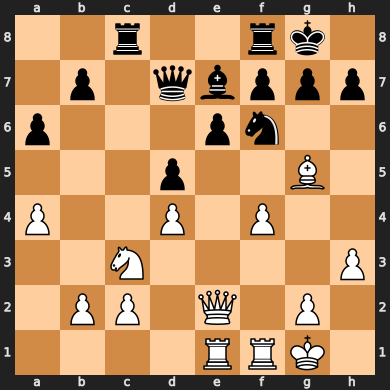

b2b3
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pb4^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Ph4^0.78125 Pg4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Nc3 Pb3 Pa3 Ph2 Pg2 Pc2 Kg1 Rf1 Rd1 Q>pb7 B>nf

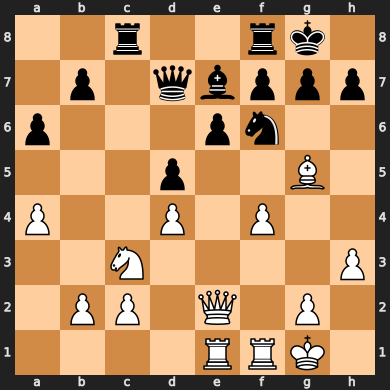

h2h4
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kh2^0.890625 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Ph5^0.890625 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Pg3^0.890625 Pb3^0.890625 Pg4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Ph4 Pf4 Pe4 Nc3 Pa3 Pg2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>pb7 B>nf

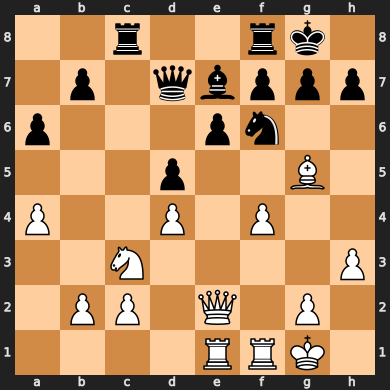

g2g4
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kg2^0.890625 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pa4^0.890625 Ph3^0.890625 Pb3^0.890625 Ph4^0.78125 Pb4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 bb4^0.671875 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pg4 Pf4 Pe4 Nc3 Pa3 Ph2 Pc2 Pb2 Kg1 Rf1 Rd1 Q>pb7 B>nf6 N>pd5 R>pd

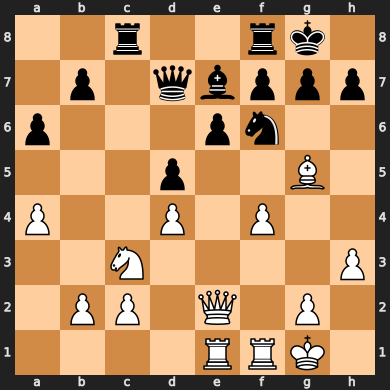

b2b4
Searching for: Qb8^0.890625 Qa8^0.890625 Qb6^0.890625 Qa6^0.890625 Qc5^0.78125 Qa5^0.78125 Qd4^0.671875 Qa4^0.671875 Qe3^0.5625 Qf2^0.453125 Bh6^0.890625 Bh4^0.890625 Nb5^0.78125 Na4^0.78125 Ne2^0.78125 Na2^0.78125 Nb1^0.78125 Kf2^0.890625 Kh1^0.890625 Rf3^0.78125 Rf2^0.890625 Re1^0.890625 Rd4^0.671875 Rd3^0.78125 Rd2^0.890625 Re1^0.890625 Rc1^0.890625 Rb1^0.78125 Ra1^0.671875 Pf5^0.890625 Pe5^0.890625 Pb5^0.890625 Pa4^0.890625 Ph3^0.890625 Pg3^0.890625 Ph4^0.78125 Pg4^0.78125 kh8^0.890625 re8^0.890625 rd8^0.78125 re8^0.78125 rd8^0.890625 rb8^0.890625 ra8^0.78125 rc7^0.890625 rc6^0.78125 rc5^0.671875 rc4^0.5625 bd8^0.890625 bd6^0.890625 bc5^0.78125 qe8^0.890625 qd8^0.890625 qc7^0.890625 qd6^0.890625 qc6^0.890625 qb5^0.78125 qa4^0.671875 ne8^0.78125 nh5^0.78125 ng4^0.78125 ph6^0.890625 pg6^0.890625 pb6^0.890625 pe5^0.890625 pd4^0.890625 ph5^0.78125 pb5^0.78125 kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 Qa7 nf6 pe6 Bg5 pd5 Pf4 Pe4 Pb4 Nc3 Pa3 Ph2 Pg2 Pc2 Kg1 Rf1 Rd1 Q>pb7 B>nf6 N>pd5 R>pd5

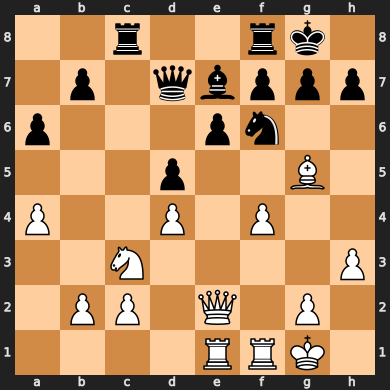

In [36]:
def score_lookup(board, bound):
    directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/games.index"))
    searcher = IndexSearcher(DirectoryReader.open(directory))
    searcher.setSimilarity(BM25Similarity())
    analyzer = WhitespaceAnalyzer()
    run(searcher, analyzer, command=encode_board_position(board), bound=bound)
    del searcher    

# Loop over all the moves and see which move generates the top document with the highest score
for move in board.legal_moves:
    board.push(move)
    print("="*20)
    print(move)
    encoding = encode_board_position(board)
    score_lookup(board, bound=1)
    board.pop()

## Observation
All the different moves lead to a position that when queried matches to the same position in the DB.
The score does vary a bit but overall it is not great that they all match the same position since then it is very difficult to reason about which move is the best.
Furthermore it becomes clear that the ```run``` function needs to be changed to output all the aggraded info rather than just printing them so that it can be used.

In [94]:
PATH = "./games/"

import os
from java.nio.file import Paths
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import NIOFSDirectory
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.analysis.core import WhitespaceAnalyzer

def run_query(searcher, analyzer, command, bound=10):
    # print ("Searching for:", command)
    escaped_command = command.replace("/", "\\/")
    query = QueryParser("contents", analyzer).parse(escaped_command)
    scoreDocs = searcher.search(query, bound).scoreDocs
    # print ("%s total matching documents." % len(scoreDocs))

    seen_games = set()
    output = []
    for scoreDoc in scoreDocs:
        doc = searcher.doc(scoreDoc.doc)
        link = f"https://lichess.org/{doc.get('game').split('.')[0]}#{int(doc.get('move'))}"
        
        if doc.get("game") in seen_games:
            # print(f"- Also found at match at position {doc.get('move')} with score {scoreDoc.score} at {link}")
            continue
        
        # print()      
        # print(f"Game: {doc.get('game')}")
        # print(f"Move: {doc.get('move')}")
        # print(f"Link: {link}")
        # print(f"Score: {scoreDoc.score}")

        file = open(os.path.join(PATH, doc.get("game")))
        file_content = str(file.read())
        content = file_content.split("\n")[int(doc.get("move"))-10].split("|")[0]
        header = file_content.split("\n")[0]
        # display(decode_piece_position(content))
        file.close()
        
        output.append([doc.get('game'), doc.get('move'), link, scoreDoc.score, content, header])
        seen_games.add(doc.get("game"))
    
    return output

In [143]:
def score_lookup(board, bound):
    output = []
    directory = NIOFSDirectory(Paths.get("/Users/tobiaswilfert/Documents/University/IR/chess-db/games.index"))
    searcher = IndexSearcher(DirectoryReader.open(directory))
    searcher.setSimilarity(BM25Similarity())
    analyzer = WhitespaceAnalyzer()
    output = run_query(searcher, analyzer, command=encode_board_position(board), bound=bound)
    del searcher  
    return output  

# Loop over all the moves and see which move generates the top document with the highest score
output = []
for move in board.legal_moves:
    board.push(move)
    
    print(f" Checking {move}")  
    encoding = encode_board_position(board)
    cur = score_lookup(board, bound=1)[0]
    cur.append(str(move))
    output.append(cur)
    board.pop()

 Checking a7b8
 Checking a7a8
 Checking a7b7
 Checking a7b6
 Checking a7a6
 Checking a7c5
 Checking a7a5
 Checking a7d4
 Checking a7a4
 Checking a7e3
 Checking a7f2
 Checking g5h6
 Checking g5f6
 Checking g5h4
 Checking c3d5
 Checking c3b5
 Checking c3a4
 Checking c3e2
 Checking c3a2
 Checking c3b1
 Checking g1f2
 Checking g1h1
 Checking f1f3
 Checking f1f2
 Checking f1e1
 Checking d1d5
 Checking d1d4
 Checking d1d3
 Checking d1d2
 Checking d1e1
 Checking d1c1
 Checking d1b1
 Checking d1a1
 Checking e4d5
 Checking f4f5
 Checking e4e5
 Checking a3a4
 Checking h2h3
 Checking g2g3
 Checking b2b3
 Checking h2h4
 Checking g2g4
 Checking b2b4


In [144]:
for x in output:
    print(x)

['hsII84BL.txt', '29', 'https://lichess.org/hsII84BL#29', 46.20036315917969, 'kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 pa6 Bg5 pd5 Pf4 Pd4 Pa4 Ph3 Nc3 Pg2 Qe2 Pc2 Pb2 Kg1 Rf1 Re1 ', "Headers(Event='Rated Blitz game', Site='https://lichess.org/hsII84BL', Date='2023.09.01', Round='-', White='dooger12345', Black='Paul1959', Result='0-1', UTCDate='2023.09.01', UTCTime='06:59:14', WhiteElo='1756', BlackElo='1713', WhiteRatingDiff='-40', BlackRatingDiff='+6', ECO='B13', Opening='Caro-Kann Defense: Exchange Variation', TimeControl='300+0', Termination='Normal')", 'a7b8']
['hsII84BL.txt', '29', 'https://lichess.org/hsII84BL#29', 46.20036315917969, 'kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 pa6 Bg5 pd5 Pf4 Pd4 Pa4 Ph3 Nc3 Pg2 Qe2 Pc2 Pb2 Kg1 Rf1 Re1 ', "Headers(Event='Rated Blitz game', Site='https://lichess.org/hsII84BL', Date='2023.09.01', Round='-', White='dooger12345', Black='Paul1959', Result='0-1', UTCDate='2023.09.01', UTCTime='06:59:14', WhiteElo='1756', BlackElo='1713', WhiteRatin

In [110]:
temp = [x + ["1-0" in x[5]] for x in output]
temp

[['hsII84BL.txt', '29', 'https://lichess.org/hsII84BL#29', 46.20036315917969, 'kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 pa6 Bg5 pd5 Pf4 Pd4 Pa4 Ph3 Nc3 Pg2 Qe2 Pc2 Pb2 Kg1 Rf1 Re1 ', "Headers(Event='Rated Blitz game', Site='https://lichess.org/hsII84BL', Date='2023.09.01', Round='-', White='dooger12345', Black='Paul1959', Result='0-1', UTCDate='2023.09.01', UTCTime='06:59:14', WhiteElo='1756', BlackElo='1713', WhiteRatingDiff='-40', BlackRatingDiff='+6', ECO='B13', Opening='Caro-Kann Defense: Exchange Variation', TimeControl='300+0', Termination='Normal')", 'a7b8', False], ['hsII84BL.txt', '29', 'https://lichess.org/hsII84BL#29', 46.20036315917969, 'kg8 rf8 rc8 ph7 pg7 pf7 be7 qd7 pb7 nf6 pe6 pa6 Bg5 pd5 Pf4 Pd4 Pa4 Ph3 Nc3 Pg2 Qe2 Pc2 Pb2 Kg1 Rf1 Re1 ', "Headers(Event='Rated Blitz game', Site='https://lichess.org/hsII84BL', Date='2023.09.01', Round='-', White='dooger12345', Black='Paul1959', Result='0-1', UTCDate='2023.09.01', UTCTime='06:59:14', WhiteElo='1756', BlackElo='1713', W

In [145]:
losing = [x for x in temp if x[7] == False]
winning = [x for x in temp if x[7] == True]

print(len(losing))
print(len(winning))

36
7


In [164]:
from chess import Move
from IPython.core.display import HTML

for x in sorted(losing, key=lambda x: x[3], reverse=True):
    move = Move.from_uci(x[6])
    print(move)
    print(f"conf: {x[3]}")
    board.push(move)
    
    no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
    display(HTML(no_wrap_div.format(chess.svg.board(board,lastmove=move, size=200), chess.svg.board(decode_piece_position(x[4]), size=200))))
    board.pop()

a3a4
conf: 50.177406311035156


a7a6
conf: 49.2476806640625


a7d4
conf: 49.078243255615234


a7f2
conf: 48.467002868652344


h2h4
conf: 47.89944076538086


a7b6
conf: 47.74528884887695


a7e3
conf: 47.31442642211914


h2h3
conf: 47.00152587890625


d1e1
conf: 46.69416046142578


a7b8
conf: 46.20036315917969


a7a8
conf: 46.20036315917969


a7a5
conf: 46.20036315917969


e4e5
conf: 46.20036315917969


a7a4
conf: 46.12107849121094


d1a1
conf: 45.94917297363281


g1h1
conf: 45.56351852416992


g2g3
conf: 45.5631217956543


g2g4
conf: 45.5631217956543


f1f3
conf: 45.28739547729492


b2b3
conf: 45.12080001831055


b2b4
conf: 45.12080001831055


g5f6
conf: 45.09217071533203


a7b7
conf: 44.80911636352539


g1f2
conf: 44.7003173828125


f4f5
conf: 44.69768142700195


d1d4
conf: 44.48701095581055


d1d3
conf: 44.48701095581055


d1d2
conf: 44.48701095581055


f1f2
conf: 44.249019622802734


a7c5
conf: 43.97637939453125


f1e1
conf: 43.64618682861328


c3e2
conf: 41.78838348388672


c3a2
conf: 41.78838348388672


c3b1
conf: 41.78838348388672


c3a4
conf: 40.9227294921875


d1d5
conf: 39.82813262939453


In [165]:
for x in sorted(winning, key=lambda x: x[3], reverse=True):
    move = Move.from_uci(x[6])
    print(move)
    print(f"conf: {x[3]}")
    board.push(move)
    
    no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
    display(HTML(no_wrap_div.format(chess.svg.board(board,lastmove=move, size=200), chess.svg.board(decode_piece_position(x[4]), size=200))))
    board.pop()

d1b1
conf: 46.8941535949707


d1c1
conf: 46.8077507019043


e4d5
conf: 43.21387481689453


g5h4
conf: 43.20003128051758


c3b5
conf: 43.03668975830078


g5h6
conf: 42.94924545288086


c3d5
conf: 42.38587951660156


## Observation

Look at only the top game is interesting to give you an idea of similar positions that are available however it is not great for evaluating the positions since it is very prone to outliers, as such looking at a wider range of games that match is probably interesting.